# <center>Exploring the Possibility of Creating New Recipes Using Machine Learning</center>

Cooking recipes are about the combination of flavors. The flavors include the natural flavors of food materials themselves and the flavors of seasoners. Some combinations are delicious, while others can be horrible. In 2016, Kiddon et. al., created coherent recipes given all ingredients and a recipe name utilizing a neural checklist model [1]. In 2019, Bodhisattwa, et. al., built a machine learning model to generate personalized recipes from incomplete input specifications and user histories based on the data collected from food.com [2]. In this work, we are more focusing on utilizing machine learning to summarize the good combination of food natural flavors and seasonings, how to cook them, and to explore the possibility of creating new recipes which are potentially able to get great reviews. We are also going to actually cook the predicted new recipes to verify whether they are delicious. 

## 1. Data Collection and Wrangling

We obtained one set of recipe and review data from kaggle.com [3]. The data set includes a recipe table and a review table, and two of them are linked through RecipeID.  

In [1]:
######################################
# Importing libraries
######################################
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
import pickle
from collections import defaultdict
import re
from pytimeparse.timeparse import timeparse
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from fuzzywuzzy import process, fuzz
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cluster import KMeans
mpl.rcParams['figure.dpi']=90
plt.rcParams["font.family"] = "arial"
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import lightgbm as lgb 
import catboost as cb
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
#######################
# Functions
#######################
def report(y_test, y_pred):
    print('-----------------------------------------------------------------------')
    cm=confusion_matrix(y_test, y_pred)
    conf_matr=pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T
    print(conf_matr)
    print('-----------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    print('-----------------------------------------------------------------------')
#########################################
# Define a class to store cv result
#########################################
class score(object):
    def __init__(self, param, scores):
        self.param=param
        self.scores=scores
        self.mean_score=np.mean(scores)

/home/yang/pyenv/env/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/home/yang/pyenv/env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to /home/yang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yang/nltk_data...
[n

We firstly loaded the recipe data, and converting the data set to a pandas DataFrame. The data set is not clean, therefore a direct call of pd.read_csv() will raise errors. We manually parsed the data set line by line.

The data set is delimited by semicolons. According to the header, there should be 10 columns in each observation. However, some observations has a number of items larger than 10. We guessed that users might put some extra semicolons somewhere. We are going to figure it out. 

In [12]:
##########################################################
# Display the column names of the recipes.csv from header
##########################################################
with open('../data/raw/recipes.csv', 'r') as file:
    recipe_column_name=pd.Series([string.strip() for string in file.readline().split(';')])
recipe_column_name

0     Recipe Name
1        RecipeID
2    Review Count
3    Recipe Photo
4          Author
5    Prepare Time
6       Cook Time
7      Total Time
8     Ingredients
9      Directions
dtype: object

In [13]:
########################################
# Loading recipes.csv
# Reading all the lines in
########################################
lines=[] # A list of lists
with open('../data/raw/recipes.csv', 'r', errors='ignore') as file:
    content=file.readlines()
    for line in content:
        lines.append([item.strip() for item in line.split(';')])
print('Numbers of items in each line after splited by semicolon:')
set([len(ele) for ele in lines])

Numbers of items in each line after splited by semicolon:


{1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23}

In [14]:
##############################################################################################################
# For each observation, there are four conditions:
# length=1: an empty line
# 1<length<10 or the second element is not a number: this content belongs to the previous line
# length=10 and the second element is a number (RecipeID): a perfect observation
# length>10 and the second element is a number (RecipeID): some users wrote extra semicolons somewhere and 
# wrongly separated one column into several items
##############################################################################################################
# Firstly, handle the condition of length=1 and 1<length<10
##############################################################################################################
cleaned_lines=[]
for line in lines:
    if len(line)>=10 and line[1].isnumeric():
        cleaned_lines.append(line)
    elif (len(cleaned_lines)>0 and len(line)<10 and len(line)>1) or (len(cleaned_lines)>0 and len(line)>=2 and not line[1].isnumeric()): 
        cleaned_lines[-1]=cleaned_lines[-1]+line
    else:
        pass
##############################################################################################################
cleaned_lines=[ele for ele in cleaned_lines if ele[0]!='Recipe Name']
print('There are {} recipes observed.'.format(len(cleaned_lines)))

There are 18453 recipes observed.


In [15]:
#####################################################
# Secondly, handle the condition of length>=10
#####################################################
recipes_dict=defaultdict(list)
for line in tqdm.tqdm(cleaned_lines):
    if len(line)>=10:
        assert line[1].isnumeric()
        # To check whether there are semicolons in Recipe Name, and the answer is no.
        assert line[5].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[5]=='X'
        assert line[6].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[6]=='X'
        assert line[7].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[7]=='X'
        assert not line[8].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric()
        # To check whether there are semicolons in Author column and three time columns, and the answer is no.
        # Therefore, the extra semicolons should be in either Ingredients column or Directions column
        # Count how many words in each segment in Ingredients column or Directions column
        word_count=[]
        for i in range(8, len(line)):
            word_count.append(len(line[i].split(' ')))
        # Here we made a simple assumption that the Diretion column should have most number of words 
        # disregarding the first ingredient column.
        # We care more about ingredients than directions, so it's OK to get more words from directions
        # to ingredients
        directions_index=np.argmax(word_count[1:])+9
        ingredients=''.join(line[8:directions_index])
        directions=''.join(line[directions_index:])
        new_line=line[:8]+[ingredients]+[directions]
        line=new_line
        assert len(line)==10
        # Now the column number of each observation is right
        for index, column_name in recipe_column_name.items():
            recipes_dict[column_name].append(line[index])
len(recipes_dict['Recipe Name'])

100%|██████████| 18453/18453 [00:00<00:00, 36926.25it/s]


18453

In [17]:
####################################################################
# Generating recipe data frame
# It seems that there are duplicated records. If recipe names and authers
# are the same, we consider they are duplicated.
####################################################################
recipes=pd.DataFrame(recipes_dict).drop_duplicates(subset=['Recipe Name', 'Author'], keep='first', ignore_index=True)
print('{} lines of duplicated recipes were dropped.'.format(len(recipes_dict['Recipe Name'])-len(recipes.index)))
recipes.info()

447 lines of duplicated recipes were dropped.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18006 entries, 0 to 18005
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Recipe Name   18006 non-null  object
 1   RecipeID      18006 non-null  object
 2   Review Count  18006 non-null  object
 3   Recipe Photo  18006 non-null  object
 4   Author        18006 non-null  object
 5   Prepare Time  18006 non-null  object
 6   Cook Time     18006 non-null  object
 7   Total Time    18006 non-null  object
 8   Ingredients   18006 non-null  object
 9   Directions    18006 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


In [18]:
################################################################################################################
# Regarding recipes:
# 1. Drop recipes without ingredient information
# 2. Convert RecipeID and review count to ingeters
# 3. Fill missing values with NaN for columns: Recipe Photo, Author, Ingredients, Directions
# 4. Convert Prepare Time, Cook Time, and Total Time to timedelta object, and to fill missing values with NaT
################################################################################################################
recipes_updated=recipes.drop(recipes[recipes['Ingredients']==''].index)
recipes_updated['RecipeID']=recipes['RecipeID'].apply(lambda x: int(x))
recipes_updated['Review Count']=recipes['Review Count'].apply(lambda x: int(x.replace('k', '000')))
recipes_updated['Recipe Photo']=recipes['Recipe Photo'].apply(lambda x: x if x!='X' else np.NaN)
recipes_updated['Author']=recipes['Author'].apply(lambda x: x if x!='X' else np.NaN)
recipes_updated['Prepare Time']=recipes['Prepare Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated['Cook Time']=recipes['Cook Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated['Total Time']=recipes['Total Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17175 entries, 0 to 18005
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Recipe Name   17175 non-null  object         
 1   RecipeID      17175 non-null  int64          
 2   Review Count  17175 non-null  int64          
 3   Recipe Photo  17175 non-null  object         
 4   Author        17175 non-null  object         
 5   Prepare Time  11843 non-null  timedelta64[ns]
 6   Cook Time     9889 non-null   timedelta64[ns]
 7   Total Time    11937 non-null  timedelta64[ns]
 8   Ingredients   17175 non-null  object         
 9   Directions    17175 non-null  object         
dtypes: int64(2), object(5), timedelta64[ns](3)
memory usage: 1.4+ MB


The second step is loading the review data, and converting the data set to a pandas DataFrame. The data set is also not clean, therefore a direct call of pd.read_csv() will raise errors either. We manually parsed the data set line by line and did the same operation as for recipes.

In [19]:
##########################################################
# Display the column names of the reviews.csv from header
##########################################################
with open('../data/raw/reviews.csv', 'r') as file:
    review_column_name=pd.Series([string.strip() for string in file.readline().split(';')])
review_column_name

0     RecipeID
1    profileID
2         Rate
3      Comment
dtype: object

In [21]:
########################################
# Loading reviews.csv
# Reading all the lines in
########################################
lines_review=[] # A list of lists
with open('../data/raw/reviews.csv', 'r', errors='ignore') as file:
    content=file.readlines()
    for line in tqdm.tqdm(content):
        lines_review.append([item.strip() for item in line.split(';')])
print('Numbers of items in each line after splited by semicolon:')
set([len(ele) for ele in lines_review])

100%|██████████| 3270508/3270508 [00:05<00:00, 584872.45it/s]


Numbers of items in each line after splited by semicolon:


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [22]:
##############################################################################################################
# For each observation, there are four conditions:
# length=1: an empty line
# 1<length<4 or the first item is not a number (RecipeID): this content belongs to the previous line
# length=4 and the first item is a number (RecipeID): a perfect observation
# length>4 and the first item is a number (RecipeID): some users wrote extra semicolons somewhere and wrongly 
# separated one column into several items
##############################################################################################################
# Firstly, handle the condition of length=1 and 1<length<4
##############################################################################################################
cleaned_lines_review=[]
for line in tqdm.tqdm(lines_review):
    if len(line)>=4 and line[0].isnumeric():
        cleaned_lines_review.append(line)
    elif (len(cleaned_lines_review)>0 and len(line)<4 and len(line)>1) or (len(cleaned_lines_review)>0 and len(line)>=1 and not line[0].isnumeric()):
        cleaned_lines_review[-1]=cleaned_lines_review[-1]+line
    else:
        pass
##############################################################################################################
cleaned_lines_review=[ele for ele in cleaned_lines_review if ele[0]!='RecipeID']
print('There are {} reviews observed.'.format(len(cleaned_lines_review)))

100%|██████████| 3270508/3270508 [00:02<00:00, 1186346.88it/s]


There are 1578721 reviews observed.


In [23]:
#####################################################
# Secondly, handle the condition of length>=4
#####################################################
reviews_dict=defaultdict(list)
for line in tqdm.tqdm(cleaned_lines_review):
    if len(line)>=4:
        assert line[0].isnumeric()
        # To check whether all the RecipeID are numbers, and the answer is YES.
        assert line[1].isnumeric()
        # To check whether all the PrefileID are numbers, and the answer is YES.
        assert line[2].isnumeric()
        # To check whether all the rates are numbers, and the answer is YES.
        # Therefore, there is only one place where users wrote extra semicolons in: comment section
        new_line=line[:3]+[''.join(line[3:])]
        line=new_line
        assert len(line)==4
        # Now the column number of each observation is right
        for index, column_name in review_column_name.items():
            reviews_dict[column_name].append(line[index])
len(reviews_dict['RecipeID'])

100%|██████████| 1578721/1578721 [00:07<00:00, 213925.18it/s]


1578721

In [24]:
####################################################################
# Generating reviews data frame
# It seems that there are duplicated records. If all the columns
# are the same, we consider they are duplicated.
####################################################################
reviews=pd.DataFrame(reviews_dict).drop_duplicates(keep='first', ignore_index=True)
print('{} lines of duplicated reviews were dropped.'.format(len(reviews_dict['RecipeID'])-len(reviews.index)))
print('{} lines left.'.format(len(reviews.index)))
reviews.info()

7894 lines of duplicated reviews were dropped.
1570827 lines left.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570827 entries, 0 to 1570826
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RecipeID   1570827 non-null  object
 1   profileID  1570827 non-null  object
 2   Rate       1570827 non-null  object
 3   Comment    1570827 non-null  object
dtypes: object(4)
memory usage: 47.9+ MB


In [25]:
################################################################################################################
# Regarding reviews:
# 1. Drop reviews without recipeID
# 2. Convert RecipeID, review count, and rate to ingeters
# 3. Fill missing values with NaN for Comments
################################################################################################################
reviews_updated=reviews[~reviews['RecipeID'].isna()]
for name in reviews.columns:
    reviews_updated[name]=reviews[name].apply(lambda x: int(x) if type(x)==str and x.isnumeric() else x)
reviews_updated.loc[reviews['Comment']=='', 'Comment']=np.NaN
reviews_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570827 entries, 0 to 1570826
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RecipeID   1570827 non-null  int64 
 1   profileID  1570827 non-null  int64 
 2   Rate       1570827 non-null  int64 
 3   Comment    1570642 non-null  object
dtypes: int64(3), object(1)
memory usage: 59.9+ MB


In [26]:
####################################################################################
# Now let's compare the two tables: how many common recipes do they have?
####################################################################################
print('There are {} recipes in recipes data set, and {} recipes in reviews data set.'.format(
    len(recipes_updated.groupby('RecipeID').count().index),
    len(reviews_updated.groupby('RecipeID').count().index)
))
print('And there are {} recipes in both data sets.'.format(
    len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values)))
))

There are 17175 recipes in recipes data set, and 9037 recipes in reviews data set.
And there are 8908 recipes in both data sets.


In [27]:
###################################################################
# Calculate the ratio of recipes with reviews in total recipes
###################################################################
print('There are {} valid recipes, and {} recipes ({:.2f}%) have reviews.'.format(
    len(recipes_updated.groupby('RecipeID').count().index), 
    len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values))), 
    float(len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values))))/float(len(recipes_updated.groupby('RecipeID').count().index))*100
))

There are 17175 valid recipes, and 8908 recipes (51.87%) have reviews.


In [28]:
###############################################################################
# We are going to investigate these 8908 recipes
# Subset the data sets 
###############################################################################
common_ID=list(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values)))
recipes_updated_2=recipes_updated[recipes_updated['RecipeID'].isin(common_ID)]
reviews_updated_2=reviews_updated[reviews_updated['RecipeID'].isin(common_ID)]
assert len(recipes_updated_2['RecipeID'].index)==recipes_updated_2['RecipeID'].nunique()
assert recipes_updated_2['RecipeID'].nunique()==reviews_updated_2['RecipeID'].nunique()
recipes=recipes_updated_2
reviews=reviews_updated_2

Only a little more than half of the recipes have reviews. We have to give up the recipes which don't have reviews because we don't know how good these recipes are.

## 2. Exploratory Data Analysis of Recipe and Review 

Time to take a look at the recipe and review data through exploratory data analysis. 

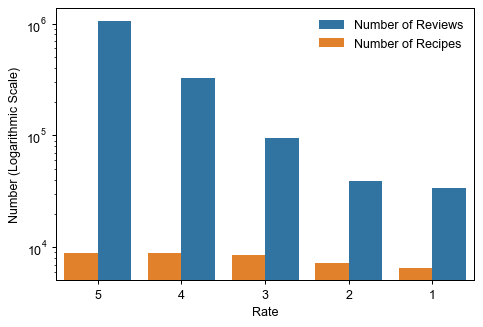

In [29]:
####################################################################################
# The rate is from 1 to 5. How many reviews and recipes fall in each category?
####################################################################################
data=pd.DataFrame({'Rate':[5, 4, 3, 2, 1],
                  'Number of Reviews': list(reviews.groupby(by='Rate')['RecipeID'].count().sort_index(ascending=False)),
                  'Number of Recipes': list(reviews.groupby(by='Rate')['RecipeID'].nunique().sort_index(ascending=False))
                  })

fig, ax=plt.subplots(1, 1)
sns.barplot(x='Rate', y='Value', hue='Variable', data=data.melt(id_vars='Rate').rename(columns=str.title), ax=ax)
ax.set_yscale('log')
ax.set_xlim(4.5, -0.5)
ax.set_xlabel('Rate')
ax.set_ylabel('Number (Logarithmic Scale)')
plt.legend(frameon=False)
plt.show()

It's clear that the qualities of recipes are quite evenly distributed. However, better recipes are more popular and attract more reviewers. Therefore we need a score to evaluate each recipe considering not only how many stars but also how many reviewers, so we can evaluate both quality and popularity by one score.    

In [30]:
############################################################################################
# What are the scores of recipes look like?
############################################################################################
# Considering using the table below to calculate a score for each recipe
# =========================================================
# Star     |      5         4       3       2        1
# ---------------------------------------------------------
# Weight   |    100        75      50      25        0
# ---------------------------------------------------------
# Meaning  | Very Good    Good    Fair   Poor   Very Poor
# =========================================================
############################################################################################
recipe_ID=list(reviews.groupby(by=['RecipeID'])['profileID'].count().index)
recipe_name=[]
for id in recipe_ID:
    recipe_name.append(recipes.loc[recipes['RecipeID']==id, 'Recipe Name'].values[0])
assert len(recipe_ID)==len(recipe_name)

In [31]:
#######################################################################################################################
# Calculate score for each recipe
# Score=100*(number of 5 star)+75*(number of 4 star)+50*(number of 3 star)+25*(number of 2 star)+0*(number of 1 star)
# For each recipe, calculate how many 5 star, 4 star, 3 star, 2 star, and 1 star it got
#######################################################################################################################
score=[]
star5=[]
star4=[]
star3=[]
star2=[]
star1=[]
ratings=reviews.groupby(['RecipeID', 'Rate'])['Rate'].count()
for id in tqdm.tqdm(recipes['RecipeID']):
    dataframe=ratings.loc[pd.IndexSlice[id, 1:5]].rename('Count')
    inner_index=dataframe.index.get_level_values(level=1)
    inner_index_weight=pd.Series(inner_index).replace({5:100, 4:75, 3:50, 2:25, 1:0})
    this_score=0
    this_star=[0,0,0,0,0] # star 5 to star 1
    for index, weight in zip(inner_index, inner_index_weight):
        count_value=dataframe[dataframe.index.get_level_values(level=1)==index].values[0]
        this_score=this_score+weight*count_value
        if index==5:
            this_star[0]=count_value
        elif index==4:
            this_star[1]=count_value
        elif index==3:
            this_star[2]=count_value
        elif index==2:
            this_star[3]=count_value
        else:
            this_star[4]=count_value
    score.append(this_score)
    star5.append(this_star[0])
    star4.append(this_star[1])
    star3.append(this_star[2])
    star2.append(this_star[3])
    star1.append(this_star[4])
assert len(score)==len(recipe_ID)==len(recipe_name)==len(star5)==len(star4)==len(star3)==len(star2)==len(star1)

100%|██████████| 8908/8908 [00:20<00:00, 431.96it/s]


In [32]:
############################################################################################
# Build the recipe score data frame
############################################################################################
recipe_score_data=pd.DataFrame({
    'Recipe Name': recipe_name,
    'Score': score,
    'Star 5': star5,
    'Star 4': star4,
    'Star 3': star3,
    'Star 2': star2,
    'Star 1': star1
}, index=recipe_ID)
recipe_score_data.index.name='RecipeID'
recipe_score_data.sort_values(by='Score', ascending=False).head(20)

,Recipe Name,Score,Star 5,Star 4,Star 3,Star 2,Star 1
RecipeID,,,,,,,
13838,Sugar Coated Pecans Recipe,97000,933,41,11,3,2
24952,Caramel Popcorn Recipe,95725,905,61,8,10,6
13436,Italian Sausage Soup with Tortellini Recipe,95625,890,76,16,5,3
20669,Double Tomato Bruschetta Recipe,95250,878,89,12,7,4
19163,Luscious Slush Punch Recipe,95250,883,82,14,4,7
17690,Sweet Dinner Rolls Recipe,95075,883,75,20,6,6
19484,Grilled Marinated Shrimp Recipe,94950,874,84,19,12,1
23822,Pumpkin Gingerbread Recipe,94950,861,102,23,2,2
20156,Clone of a Cinnabon Recipe,94950,886,69,21,5,9


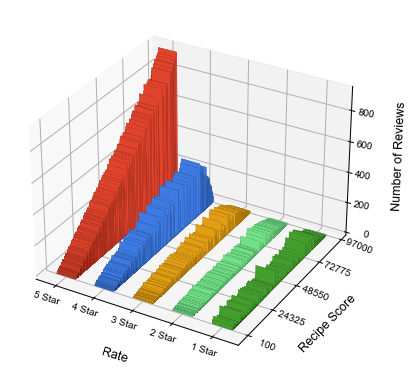

In [33]:
############################################################################################
# Plot 3-D bar
############################################################################################
data=recipe_score_data.sort_values(by='Score', ascending=False)[:]
#==============================================================
fig=plt.figure()
ax=Axes3D(fig)
lx=5          
ly=len(data.index)
xpos=np.arange(0,lx,1)    
ypos=data['Score']
xpos, ypos=np.meshgrid(xpos-0.2, ypos)
xpos=xpos.flatten()   
ypos=ypos.flatten()
zpos=np.zeros(lx*ly)

dx=0.5*np.ones_like(zpos)
dy=dx.copy()
dz=data[['Star 5', 'Star 4', 'Star 3', 'Star 2', 'Star 1']].values.flatten()
cs=[(1, 0.3, 0.2), (0.27,0.54,1), (1, 0.7, 0.09), (0.5, 1, 0.6), (0.3, 0.7, 0.2)]*ly
ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)
ax.set_xlabel('Rate', rotation=(-17))
ax.set_ylabel('Recipe Score')
ax.set_zlabel('Number of Reviews')
ax.set_xticks([i for i in range(5)])
ax.set_xticklabels(rotation=(-17), fontsize=8, va='bottom', ha='center', 
                   labels=['5 Star', '4 Star', '3 Star', '2 Star', '1 Star'])
ax.set_yticks([i+2000 for i in np.linspace(data.iloc[0, 1], data.iloc[-1, 1], num=5, endpoint=True)])
y_labels=['  {:.0f}'.format(x) for x in np.linspace(data.iloc[0, 1], data.iloc[-1, 1], num=5, endpoint=True)] 
ax.set_yticklabels(rotation=(-21), fontsize=8, va='bottom', ha='center', labels=y_labels)
ax.set_zticks([x for x in np.linspace(0, 800, num=5, endpoint=True)])
ax.set_zticklabels(rotation=(-10), fontsize=8, va='top', ha='right', labels=[0, 200, 400, 600, 800])
plt.show()

It seems that 5 star and 4 star reviews have occupied the majority of the total reviews. The recipes are distributed in a wide range of recipe score (from 100 to 97000), indicating a large variation of quality and popularity level of the recipes. The recipe score is a good indicator for our study.

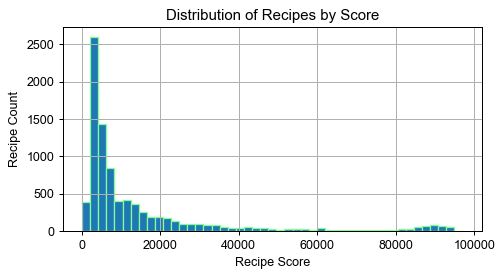

In [34]:
#################################################
# Distribution of scores
#################################################
fig, ax=plt.subplots(1, 1, figsize=(6,3))
recipe_score_data['Score'].hist(bins=int(np.sqrt(len(recipe_score_data.index))/2), edgecolor=(0.5, 1, 0.6))
ax.set_xlabel('Recipe Score')
ax.set_ylabel('Recipe Count')
ax.set_title('Distribution of Recipes by Score')
plt.show()

The distribution of recipes is not even. The majority of the recipes are not good. Only a small portion of recipes have better quality (score of which is larger than 80,000). Interestly, the number of fair recipes is even less (score of which is in a range of 40,000 to 80,000). Selection bias maybe kick in: people would like to give reviews on really good recipes or really bad recipes. But it doesn't affect our investigation, because we are only interested in really good recipes. 

In [35]:
#################################################
# Save the cleaned data
#################################################
with open('../data/processed/recipes.pkl', 'wb') as file:
    pickle.dump(recipes, file)
with open('../data/processed/reviews.pkl', 'wb') as file:
    pickle.dump(reviews, file)
with open('../data/processed/scores.pkl', 'wb') as file:
    pickle.dump(recipe_score_data, file)

## 3. Feature Engineering and Unsupervised Learning

### 3.1 Build One-hot Encoding Ingredients Data Frame

Our interest is to find out what combination of food materials and/or seasoners would lead to good recipes. Therefore we need to extract the information about the food materials and seasoners from recipes, and figure out what good or bad combinations look like.

In [36]:
##################################################
# Load the cleaned data
##################################################
with open('../data/processed/recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('../data/processed/reviews.pkl', 'rb') as file:
    reviews=pickle.load(file)
with open('../data/processed/scores.pkl', 'rb') as file:
    scores=pickle.load(file)
print('Dataframe recipes: \t{} rows \t{} columns.'.format(recipes.shape[0], recipes.shape[1]))
print('Dataframe reviews: \t{} rows \t{} columns.'.format(reviews.shape[0], reviews.shape[1]))
print('Dataframe scores: \t{} rows \t{} columns.'.format(scores.shape[0], scores.shape[1]))

Dataframe recipes: 	8908 rows 	10 columns.
Dataframe reviews: 	1554110 rows 	4 columns.
Dataframe scores: 	8908 rows 	7 columns.


Not all the words in the ingredients column are actual ingredients. Some words like measure words or verbs are not the ones we need. One possible approach for selecting these not-ingredient words out is based on an assumption that these words may appear with higher frequency. 

In [37]:
##########################################################
# Find higher frequcency words in ingredients column
##########################################################
words0=recipes.loc[:, 'Ingredients'].sum().lower()
words1=re.sub('[\(\[].*?[\)\]]', '', words0) # Remove content in parentheses
words2=re.sub(r'[0-9]+', '', words1).replace('/', '').replace('**', ' ').replace(',', ' ').replace('.', ' ').replace('-', ' ')
words=[word for word in words2.split(' ') if word]
words_frequency=pd.DataFrame({'Words': words})['Words'].value_counts()
print('Found {} words from ingredients column.'.format(len(words_frequency)))

Found 3809 words from ingredients column.


Apparently some of the high frequency words are still ingredients but a lot more are not. We marked those top 200 high frequency words which are not ingredients, together with some other common not-ingredient words, to build a list of non-ingredient words.

In [38]:
words_frequency[:200].to_dict().keys()

dict_keys(['cup', 'teaspoon', 'cups', 'and', 'sugar', 'chopped', 'tablespoons', 'salt', 'white', 'ground', 'butter', 'flour', 'pepper', 'to', 'tablespoon', 'all', 'can', 'purpose', 'cheese', 'cream', 'teaspoons', 'baking', 'a', 'oil', 'powder', 'package', 'onion', 'water', 'vanilla', 'eggs', 'milk', 'in', 'garlic', 'extract', 'fresh', 'the', 'chicken', 'sliced', 'black', 'large', 'dried', 'taste', 'egg', 'brown', 'sauce', 'pound', 'mix', 'minced', 'green', 'of', 'shredded', 'soda', 'vegetable', 'diced', 'softened', 'juice', 'chocolate', 'until', 'ounces', 'drained', 'cinnamon', 'lemon', 'into', 'cloves', 'for', 'peeled', 'olive', 'beef', 'red', 'pounds', 'dry', 'bowl', 'oven', 'grated', 'tomatoes', 'condensed', 'medium', 'crushed', 'frozen', 'f', 'add', 'degrees', 'with', 'soup', "confectioners''", 'packed', 'inch', 'onions', 'melted', 'or', 'bell', 'cut', 'cans', 'celery', 'boneless', 'cheddar', 'sour', 'tomato', 'bread', 'beaten', 'heat', 'potatoes', 'chips', 'pinch', 'broth', 'parsl

In [39]:
###########################################
# A list of non-ingredient words
###########################################
non_ingredient_words=['cup', 'teaspoon', 'cups', 'and', 'chopped', 'tablespoons', 
                      'white', 'ground', 'to', 'tablespoon',
                      'can', 'teaspoons', 'a', 
                      'package', 'water', 'fresh', 'the', 'sliced', 'large', 'dried', 
                      'taste', 'pound', 'in', 'green', 'of',
                      'shredded', 'mix', 'diced', 'softened', 'until', 'ounces', 'drained', 'into',
                      'peeled', 'for', 'pounds', 'dry', 'bowl',
                      'oven', 'grated', 'medium', 'condensed', 'crushed', 'frozen',
                      'F', 'degrees', 'with', 'packed', 'inch', 'melted', 'or', 'bell', 'cans', 'In', 'cut', 'boneless',
                      'Add', 'sour', 'beaten', 'pinch', 'skinless', 'heat', 'small',
                      'cubed', 'minutes', 'together',
                      'shortening', 'halves', 'cooked', 'whole',   
                      'thawed', 'over', 'heavy', 'slices',
                      'unsweetened', 'packages', 'finely', 'pieces', 'seasoning', 'hot', 'style', 'boil', 'container', 
                      'lightly', 'instant', 'pot', 'Italian', 
                      'prepared', 'thinly', 'half', 'light', 
                      'pan', 'skillet', 'cook', 'flavored', 
                      'combine', 'divided', 'yellow', 
                      'jar', 'whipped', 'topping', 'lean',
                      'uncooked', 'Combine', 'recipe', 
                      'sweet', 'Stir', 'warm', 'active', 'room', 'temperature', 'ounce', 'gallon',
                      'other', 'drops', 'Sift', 'bottle', 'soaked', 'hours', 'hour', 'about', 'minute', 'gather', 'it']

In [40]:
#############################################################
# Find a list of possible ingredients
#############################################################
ingredients_list=[]
ingredients0=recipes[['RecipeID', 'Ingredients']].reset_index()
for row in tqdm.tqdm(ingredients0['Ingredients'].values):
    string1=re.sub(r'[\(\[].*?[\)\]]', '', row).lower()
    string2=re.sub(r'[0-9]+', '', string1).replace('/', '').replace('**', ' ** ').replace(',', ' , ').replace('.', ' . ')
    string3=' '.join([word for word in string2.split(' ') if word not in non_ingredient_words]).strip()
    ingreds0=[word for word in [word.strip() for word in string3.split('**')] if word]
    ingreds1=[words for words in ingreds0 if len(words.split(' '))<=6]
    ingreds=[word for word in [words.replace(',', '').replace("'", "").strip() for words in ingreds1] if word]
    ingredients_list.extend(ingreds)
ingredients_list=[ing.replace('*', '').strip() for ing in list(set(ingredients_list))]
print('Found {} ingredients.'.format(len(ingredients_list)))

100%|██████████| 8908/8908 [00:00<00:00, 12896.53it/s]

Found 4424 ingredients.


In [41]:
#########################################################
# Trim the ingredient list
#########################################################
ingredients_list0=[ing.replace('.', '').replace(':', '').replace('  ', ' ').strip().lower() for ing in ingredients_list]

In [42]:
#####################################################################################
# Find similiar ingredients and combine them (string comparison ratio >= 95%)
#####################################################################################
Dict=defaultdict(list)
Dict[ingredients_list0[0]].append(ingredients_list0[0])
for index, item in tqdm.tqdm(enumerate(ingredients_list0, start=1)):
    flag=False
    for key, value in Dict.items():
        if fuzz.WRatio(item, value[0])>=95:
            Dict[key].append(item)
            flag=True
            break
    if not flag:
        Dict[item].append(item)
print('Found {} different ingredients based on 95% string similarity.'.format(len(Dict.keys())))
count=0
for key, value in Dict.items():
    if len(value)>1:
        print(key, ': ', value)
        count+=1
        if count>10: break

4424it [37:27,  1.97it/s]

Found 3483 different ingredients based on 95% string similarity.
tomato -  seeded :  ['tomato -  seeded', 'tomato -  seeded', 'tomato  seeded']
jars pizza sauce :  ['jars pizza sauce', 'pizza sauce']
pineapple chunks  reserve juice :  ['pineapple chunks  reserve juice', 'pineapple chunks juice']
lemon pudding :  ['lemon pudding', 'lemon cake pudding']
red potatoes  quartered :  ['red potatoes  quartered', 'potatoes  quartered', 'unpeeled red potatoes  quartered', 'quartered new red potatoes']
egg whitespreheat f :  ['egg whitespreheat f', 'egg whitepreheat f']
tomatoes  seeded coarsely :  ['tomatoes  seeded coarsely', 'tomatoes -  seeded']
pastry double-crust pie :  ['pastry double-crust pie', 'pastry -inch double-crust pie', 'pastry double crust pie', 'pastry double-crust pie']
minced shallots :  ['minced shallots', 'shallots  minced', 'minced shallot']
chile pepper :  ['chile pepper', 'chile peppers', 'red chile pepper']
mashed bananas :  ['mashed bananas', 'mashed ripe bananas', 'ba

In [43]:
##################################################################
# Build one-hot encoding ingredient data frame
# This is a sparse matrix with most of the value zero
##################################################################
ingredients1=ingredients0[['RecipeID', 'Ingredients']].copy()
###############################################################
# Construct whole data frame with all zeros
###############################################################
for key, value in tqdm.tqdm(Dict.items()):
    ingredients1[key]=0
ingredients1.iloc[:10, :5]

100%|██████████| 3483/3483 [00:05<00:00, 653.52it/s] 


,RecipeID,Ingredients,tomato - seeded,chili oil,jars pizza sauce
0,7000,2 (.25 ounce) packages active dry yeast**3/4 c...,0,0,0
1,7001,'3 cups all-purpose flour**1 1/2 teaspoons sal...,0,0,0
2,7003,3 cups all-purpose flour**3 eggs**2 cups white...,0,0,0
3,7009,1/3 cup shortening**1 cup hot water**1 cup pac...,0,0,0
4,7010,2 cups milk**1/2 cup warm water (110 degrees F...,0,0,0
5,7011,1 tablespoon active dry yeast**1 teaspoon whit...,0,0,0
6,7013,1 cup margarine**1 1/4 cups white sugar**1 egg...,0,0,0
7,7245,2 1/4 teaspoons active dry yeast**1/2 teaspoon...,0,0,0
8,7246,2 cups white sugar**2 cups sifted all-purpose ...,0,0,0
9,7251,1/2 cup butter**1/2 cup vegetable oil**1 3/4 c...,0,0,0


In [44]:
###########################################################
# Check Ingredients column and fill in the numeric columns
###########################################################
ingredients2=ingredients1.copy()
for index, row in tqdm.tqdm(ingredients2.iterrows()):
    string=row.loc['Ingredients'].lower()
    string1=re.sub(r'[\(\[].*?[\)\]]', '', string)
    string2=re.sub(r'[0-9]+', '', string1).replace('/', '').replace('**', ' ** ').replace(',', ' , ').replace('.', ' . ')
    string3=' '.join([word for word in string2.split(' ') if word not in non_ingredient_words]).strip()
    ingreds0=[word for word in [word.strip() for word in string3.split('**')] if word]
    ingreds1=[words for words in ingreds0 if len(words.split(' '))<=6]
    ingreds2=[word.replace('*', '').strip() for word in [words.replace(',', '').replace("'", "").strip() for words in ingreds1] if word]
    ingreds=[ing.replace('.', '').replace(':', '').replace('  ', ' ').strip().lower() for ing in ingreds2]
    for ing in ingreds:
        for key, value in Dict.items():
            if ing in value:
                ingredients2.iloc[index, ingredients2.columns.get_loc(key)]=1
                break
ingredients=ingredients2.drop(columns=['Ingredients'])
with open('../data/processed/ingredients.pkl', 'wb') as file:
    pickle.dump(ingredients, file)
print('There are {} rows and {} columns in the ingredients data frame.'.format(ingredients.shape[0], ingredients.shape[1]))

8908it [00:23, 376.05it/s]


There are 8908 rows and 3484 columns in the ingredients data frame.


There is a question: how many ingredients one recipe is using? When we build a new recipe, we don't want to use too many kinds of ingredients or too few. We use histograms and kernel density estimation (KDE) to describe the number of ingredients in existing recipes. 

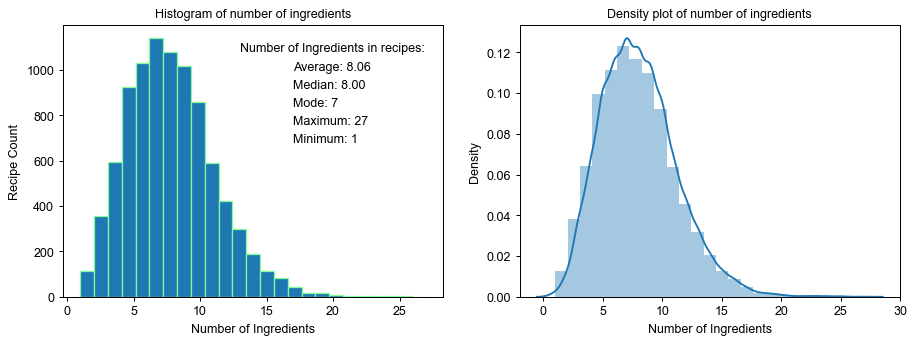

In [45]:
####################################################################
# Find the information about numbers of ingredients for each recipe
####################################################################
with open('../data/processed/ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
#################################################################
ingredients['Ingredient Count']=ingredients.iloc[:, 1:].sum(axis=1)
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(ingredients['Ingredient Count'], bins=25, edgecolor=(0.5,1,0.6))
ax1.set_xlabel('Number of Ingredients')
ax1.set_ylabel('Recipe Count')
ax1.set_title('Histogram of number of ingredients', fontsize=10)
ax1.text(13, 1080, 'Number of Ingredients in recipes:')
ax1.text(17, 1000, 'Average: {:.2f}'.format(ingredients['Ingredient Count'].mean()))
ax1.text(17, 920, 'Median: {:.2f}'.format(ingredients['Ingredient Count'].median()))
ax1.text(17, 840, 'Mode: {}'.format(ingredients['Ingredient Count'].mode().values[0]))
ax1.text(17, 760, 'Maximum: {}'.format(ingredients['Ingredient Count'].max()))
ax1.text(17, 680, 'Minimum: {}'.format(ingredients['Ingredient Count'].min()))
###################################################################
sns.distplot(ingredients['Ingredient Count'], hist=True, kde=True, bins=25, ax=ax2)
ax2.set_title('Density plot of number of ingredients', fontsize=10)
ax2.set_xlabel('Number of Ingredients')
###################################################################
plt.show()

It seems that most of the recipes have 7~8 ingredients. 

Now we have made a one-hot encoding ingredients data frame with ingredients as column names. This data frame can help us with the question about the underlying relationship between the combination of ingredients and the quality of recipes. 

There are over 3000 ingredients in the data set. We need to remove the rarely used ones to reduce the dimensions.

In [46]:
####################################################
# Remove rare ingredients (only used once or twice)
####################################################
with open('../data/processed/ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
#################################################################################
mask=ingredients.drop(columns=['RecipeID']).sum(axis=0)<=2
ingredients2=ingredients.drop(columns=[name for name in mask.index if mask[name]])
ingredients2.shape

(8908, 1381)

In [47]:
########################################################################################
# Delete recipes without any ingredients after deleting rare ingredients (only four)
########################################################################################
ingredients_final=ingredients2[ingredients2.drop(columns=['RecipeID']).sum(axis=1)>0]
ingredients_final.shape

(8902, 1381)

In [48]:
ingredients_final.iloc[:5, :8]

,RecipeID,tomato - seeded,chili oil,jars pizza sauce,pineapple chunks reserve juice,lemon pudding,italian-style,red potatoes quartered
0,7000,0,0,0,0,0,0,0
1,7001,0,0,0,0,0,0,0
2,7003,0,0,0,0,0,0,0
3,7009,0,0,0,0,0,0,0
4,7010,0,0,0,0,0,0,0


### 3.2 Build One-hot Encoding Cooking methods Data Frame

Good food needs both unique combination of recipes and appropriate cooking methods. Next step I am going to extract key words from the Directions as features to build one-hot encoding cooking methods data frame.

In [49]:
##################################################
# Load the clean data
##################################################
with open('../data/processed/recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
###########################################################################
# Use the same RecipeID in ingredients_final to make Direction data frame
###########################################################################
methods0=pd.merge(ingredients_final[['RecipeID']], recipes[['RecipeID', 'Directions']], on='RecipeID', how='left')
methods0.shape

(8902, 2)

In [50]:
############################################
# Extract cooking keywords from Directions
############################################
words0=methods0.loc[:, 'Directions'].sum().lower()
words1=re.sub('[\(\[].*?[\)\]]', '', words0)
words2=re.sub(r'[0-9]+', ' ', words1)
words3=re.sub(r'[^a-zA-Z]+', ' ', words2)
words4=list(set([word for word in words3.split(' ') if word and word not in set(stopwords.words('english'))]))

In [51]:
#####################################################
# Get rid of words which are less than 3 characters
#####################################################
words5=[word for word in words4 if len(word)>=3]
#####################################################
# Use Lemmatization to root words and tag POS
# Select all the verbs as cooking methods
#####################################################
words6=list(set([WordNetLemmatizer().lemmatize(word) for word in words5]))
words7=nltk.pos_tag(words6)
verbs=['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
words=[word for (word, tag) in words7 if tag in verbs]
print('Find {} words in cooking methods.'.format(len(words)))

Find 1012 words in cooking methods.


In [52]:
###############################################################
# Construct whole methods data frame with all zeros
###############################################################
methods1=methods0.copy()
for word in words:
    methods1[word]=0
methods1.shape

(8902, 1014)

In [53]:
###########################################################
# Check Directions column and fill in the numeric columns
###########################################################
methods2=methods1.copy()
for index, row in tqdm.tqdm(methods2.iterrows()):
    string=row.loc['Directions'].lower()
    string1=re.sub(r'[\(\[].*?[\)\]]', '', string)
    string2=re.sub(r'[0-9]+', '', string1)
    string3=re.sub(r'[^a-zA-Z]+', ' ', string2)
    token4=list(set([word for word in string3.split(' ') if word and word not in set(stopwords.words('english'))]))
    token5=[word for word in token4 if len(word)>=3]
    token=list(set([WordNetLemmatizer().lemmatize(word) for word in token5]))
    for word in token:
        if word in methods2.columns:
            methods2.iloc[index, methods2.columns.get_loc(word)]=1
methods=methods2.drop(columns=['Directions'])
with open('../data/processed/methods.pkl', 'wb') as file:
    pickle.dump(methods, file)
print('There are {} rows and {} columns in the methods data frame.'.format(methods.shape[0], 
                                                                           methods.shape[1]))

8902it [01:30, 98.38it/s] 


There are 8902 rows and 1013 columns in the methods data frame.


In [55]:
######################################################################
# Remove rare methods to reduce dimensions (only used once or twice)
######################################################################
with open('../data/processed/methods.pkl', 'rb') as file:
    methods=pickle.load(file)
#################################################################################
mask=methods.drop(columns=['RecipeID']).sum(axis=0)<=2
methods_final=methods.drop(columns=[name for name in mask.index if mask[name]])
methods_final.shape

(8902, 494)

### 3.3 Principal Component Analysis and t-SNE analysis

After appropriate dimension reduction, the ingredients data frame still contains 1388 ingredients, and the methods data frame contains 490 methods. The data frame is probably suffering from curse of dimensions. I am going to use principal component analysis (PCA) and t-SNE analysis to evaluate the situation. 

In order to simplify the modeling, I can make the quality of recipes a classification problem. I label recipes as good ones (score >= 80000) and bad ones (score < 80000), and mark 1 for the good ones and 0 for the bad ones. The good recipes and the bad recipes are also shown in PCA and t-SNE analyses.

In [56]:
#############################################################
# Prepare the one-hot encoding data frame
#############################################################
with open('../data/processed/scores.pkl', 'rb') as file:
    scores=pickle.load(file)
#############################################################
pcaing0=pd.merge(ingredients_final, methods_final, on='RecipeID', how='left').set_index('RecipeID')
pcaing1=pcaing0.merge(scores[['Score']], how='left', on='RecipeID')
pcaing1['Label']=pcaing1['Score'].apply(lambda x: 1 if x>=80000 else 0)
pcaing=pcaing1.drop(columns=['Score'])
#############################################################
# Final data frame for modeling
#############################################################
with open('../data/processed/data.pkl', 'wb') as file:
    pickle.dump(pcaing, file)
#############################################################

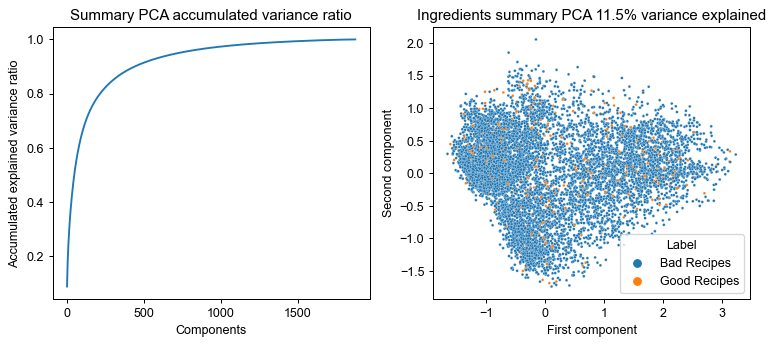

In [57]:
#############################################################
# PCA analysis
#############################################################
with open('../data/processed/data.pkl', 'rb') as file:
    data=pickle.load(file)
pca=PCA().fit(data.drop(columns=['Label']))
pca_x=pca.transform(data.drop(columns=['Label']))
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 4))
_=ax1.plot(pca.explained_variance_ratio_.cumsum())
_=ax1.set_xlabel('Components')
_=ax1.set_ylabel('Accumulated explained variance ratio')
_=ax1.set_title('Summary PCA accumulated variance ratio')
_=sns.scatterplot(
    x=pca_x[:, 0], 
    y=pca_x[:, 1], 
    s=5, 
    hue=data['Label'].apply(lambda x: 'Good Recipes' if x==1 else 'Bad Recipes'), 
    ax=ax2)
_=ax2.set_xlabel('First component')
_=ax2.set_ylabel('Second component')
_=ax2.set_title(
    'Ingredients summary PCA {:.1f}% variance explained'.format(100*pca.explained_variance_ratio_.cumsum()[1]))
plt.show()

It costs over 700 components to reach 90% variance explained, and the first two components can only explain 11.5% variance. It seems that the variance cannot be concentrated into several principal components. I have to go through higher dimensions to get my question answered. Also I noticed that, from the first two components, all the recipes naturally separate into several clusters. It is intuitive because different regions of the world have different type of food styles, and recipes in same regions are similar. Also the good recipes are almost evenly distributed in each clusters from the first two components of PCA analysis, which brings difficulties to the supervised learning. 

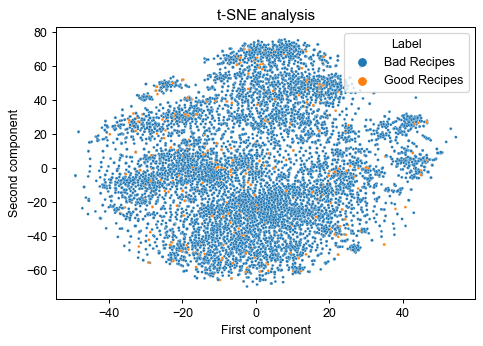

In [58]:
#############################################################
# t-SNE analysis
#############################################################
X_embedded=TSNE().fit_transform(data.drop(columns=['Label']))
_=sns.scatterplot(X_embedded[:,0], 
                  X_embedded[:,1], 
                  hue=data['Label'].apply(lambda x: 'Good Recipes' if x==1 else 'Bad Recipes'),
                  s=5)
_=plt.xlabel('First component')
_=plt.ylabel('Second component')
_=plt.title('t-SNE analysis')
plt.show()

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. It can be seen from the above plot that the recipes can be separated into many different clusters. However, like the PCA result, the good recipes are almost evenly distributed in the whole area as well. It is not an easy task to distinguish good recipes and bad recipes by a simple clustering. I am going to do unsupervised learning first to analysis the data set, and focus on the supervised learning to find new and potentially good recipes later. 

### 3.4 K-means Clustering and Topic Modeling

I am about to answer other two questions: whether all these recipes can be devided into groups according to similiarity of these recipes regarding ingredients, and whether one group can be better than other groups. I will focus on the top 500 recipes, use ELBOW method [4] to determine k value for k-means clustering, and perform k-means clustering followed by pricipal component analysis (PCA) for visualization [5]. Also topic modeling (Latent Dirichlet Allocation: LDA) [6] is able to help with understanding how ingredients and cooking methods are relevant to the recipe score. 

In [59]:
##########################################################################
# Take top 500 recipes for EDA
# When performing k-means clustering, the score column is not included
##########################################################################
with open('../data/processed/scores.pkl', 'rb') as file:
    scores=pickle.load(file)
cluster=data.merge(scores[['Score']], how='left', on='RecipeID').sort_values(by='Score', ascending=False).iloc[:500]
cluster0=cluster.drop(columns=['Label', 'Score'])    
cluster.iloc[:10, -5:]

,dissolved,minutesstirring,unbaked,Label,Score
RecipeID,,,,,
13838,0,0,0,1,97000
24952,0,0,0,1,95725
13436,0,0,0,1,95625
19163,0,0,0,1,95250
20669,0,0,0,1,95250
17690,0,0,0,1,95075
23822,0,0,0,1,94950
20156,0,0,0,1,94950
19484,0,0,0,1,94950


In [60]:
######################################################
# Use elbow method to determine k value
######################################################
distortions=[]
k_values=range(1, 21)
for k in k_values:
    kmean=KMeans(n_clusters=k)
    kmean.fit(cluster0)
    distortions.append(kmean.inertia_)

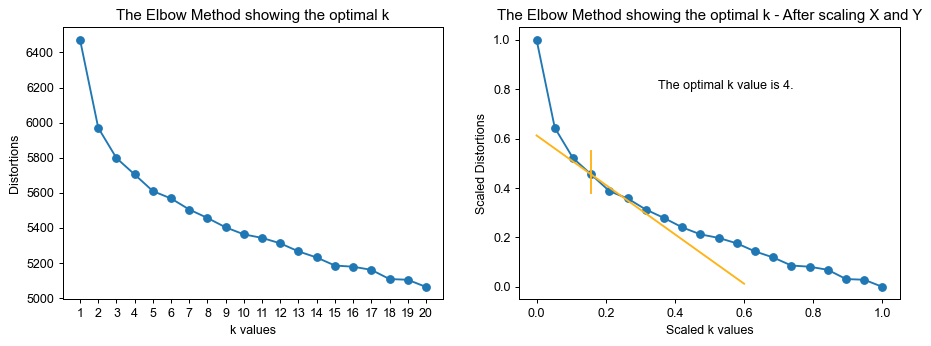

In [61]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
######################################################################
ax1.plot(k_values, distortions, '-o')
ax1.set_xlabel('k values')
ax1.set_ylabel('Distortions')
ax1.set_title('The Elbow Method showing the optimal k')
ax1.set_xticks(range(1, 21))
######################################################################
# MinMaxScaler for k values and distrotions to determine elbow point
######################################################################
plotdata=[[x1, x2] for x1, x2 in zip(k_values, distortions)]
scaler=MinMaxScaler()
scaler.fit(plotdata)
scaler_data=scaler.transform(plotdata)
ax2.plot([x[0] for x in scaler_data], [y[1] for y in scaler_data], '-o')
ax2.plot([0, 0.6], [[x[0]+x[1] for x in scaler_data][3]-y for y in [0, 0.6]], c=(1, 0.7, 0.09))
ax2.plot([[x[0] for x in scaler_data][3], [x[0] for x in scaler_data][3]], [0.38, 0.55], c=(1, 0.7, 0.09))
ax2.set_xlabel('Scaled k values')
ax2.set_ylabel('Scaled Distortions')
ax2.set_title('The Elbow Method showing the optimal k - After scaling X and Y')
ax2.text(0.35, 0.8, 'The optimal k value is 4.')
######################################################################
plt.show()

The optimal k value is determined to be 4 after performing the elbow method [7]. Next I am going to perform k-means clustering with a cluster number of 4 on ingredients and methods data frame, and visualized the result by principal component analysis. Also we are going to explore the relationship between clusters and recipe scores. 

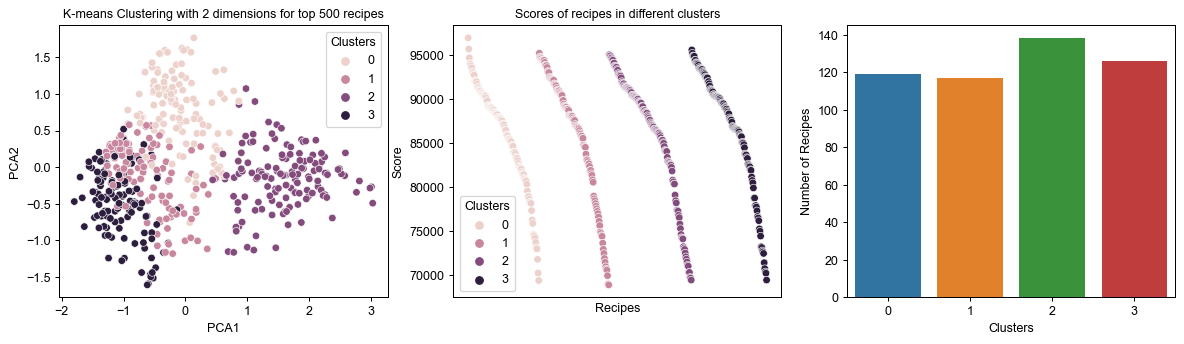

In [62]:
###################################################################################
# Performing  k-means clustering with  and PCA analysis to reduce to 2 dimensions
###################################################################################
fig, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(16, 4))
###################################################################################
kmeans=KMeans(n_clusters=4)
cluster0['Clusters']=kmeans.fit_predict(cluster0)
pca_cluster0=cluster0.drop(columns='Clusters')
reduced_data=PCA(n_components=min(pca_cluster0.shape[0], pca_cluster0.shape[1])).fit_transform(pca_cluster0)
results=pd.DataFrame(reduced_data).iloc[:, 0:2]
results.columns=['PCA1', 'PCA2']
results['Clusters']=cluster0['Clusters'].values
sns.scatterplot(x=results["PCA1"], y=results["PCA2"], hue=results['Clusters'], ax=ax1)
ax1.set_title('K-means Clustering with 2 dimensions for top 500 recipes', fontsize=10)
######## Scores #########################################
plotdata=cluster
score_cluster=pd.concat([plotdata['Score'].reset_index(), pd.DataFrame({'Clusters': results['Clusters']})], axis=1)
plotdata=score_cluster.sort_values(by=['Clusters', 'Score'], ascending=[True, False]).reset_index()
sns.scatterplot(x=plotdata.index, y=plotdata['Score'], hue=plotdata['Clusters'], ax=ax2)
ax2.set_xticks([])
ax2.set_xticks([], minor=True)
ax2.set_xlabel('Recipes')
ax2.set_title('Scores of recipes in different clusters', fontsize=10)
####### Number of recipes in each cluster ###############
bar=plotdata.groupby('Clusters').count().reset_index()
sns.barplot(data=bar, x='Clusters', y='RecipeID', ax=ax3)
ax3.set_ylabel('Number of Recipes')
#########################################################
plt.show()

The first two dimensions of principal component analysis exhibit that the top 500 recipes have been separated into four groups regarding ingredients, indicating that they might from different types of cuisines or from different regions of the world. Moreover, the recipe scores are evenly distributed in each cluster. The qualities of each type of recipes exhibit no significant difference. Not any type of recipes prevails (but if considering the number of recipes which are in top 500, one of the clusters significantly wins out). Therefore I may treat these four types of recipes evenly.

Next I use natural language proessing (NLP) topic modeling (Latent Dirichlet Allocation: LDA algorithm) to explore the topics of top 500 recipes regarding names, ingredients, and cooking methods. Firstly I create vocabulary of all the words, and then we use LDA to create topics along with the probability distribution for each word in the vocabulary for each topic [6, 8, 9]. 

In [63]:
plotdata=cluster.copy()
with open('../data/processed/recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
###########################################################
def remove_non_ingredient_words(string, non_ingredient_words):
    words=[word for word in gensim.utils.simple_preprocess(str(string), deacc=True) if word not in non_ingredient_words]
    return ' '.join(words).strip()
###########################################################
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
###########################################################
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
###########################################################
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values=[]
    model_list=[]
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
############################################################
# Analyze recipe name, ingredients, and directions
############################################################
lda_data=plotdata[['Score']].merge(recipes[['RecipeID', 'Recipe Name', 'Ingredients', 'Directions']].set_index('RecipeID'), 
                                   how='left', on='RecipeID')
text0=pd.DataFrame(lda_data['Recipe Name']+' '+lda_data['Ingredients']+' '+lda_data['Directions'], columns=['Text'])
text1=pd.DataFrame(text0['Text'].str.replace(r'[0-9]+', ' ').str.replace(r'[\(\[].*?[\)\]]', ' '))
text2=pd.DataFrame(text1['Text'].str.replace(r'[^a-zA-Z]+', ' '))
text=pd.DataFrame(text2['Text'].apply(lambda x: remove_non_ingredient_words(x, non_ingredient_words)))
stop_words=stopwords.words('english')
lda_data=text['Text'].values.tolist()
data_words=list(sent_to_words(lda_data))
data_words=remove_stopwords(data_words)
id2word=corpora.Dictionary(data_words)
corpus=[id2word.doc2bow(text) for text in data_words]
model_list, coherence_values=compute_coherence_values(dictionary=id2word,
                                                      corpus=corpus,
                                                      texts=data_words,
                                                      start=2, limit=20, step=2)

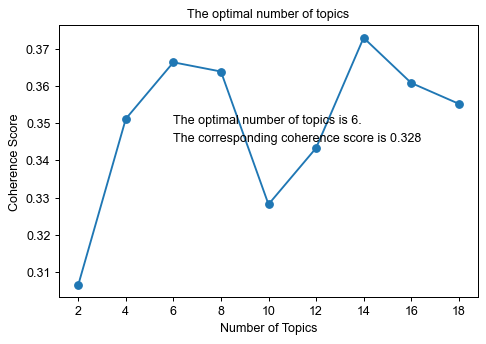

In [68]:
x=range(2, 20, 2)
fig, ax1=plt.subplots(1, 1, figsize=(6, 4))
######################################################################
ax1.plot(x, coherence_values, '-o')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_title('The optimal number of topics', fontsize=10)
ax1.set_xticks(x)
ax1.text(6, 0.35, 'The optimal number of topics is 6.')
ax1.text(6, 0.345, 'The corresponding coherence score is {:.3f}'.format(coherence_values[4]))
######################################################################
plt.show()

In [69]:
######################################################
# Build the LDA model
######################################################
lda_model=gensim.models.LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=6)
pprint(lda_model.print_topics())

[(0,
  '0.025*"pepper" + 0.022*"salt" + 0.017*"onion" + 0.016*"sugar" + '
  '0.015*"chicken" + 0.015*"sauce" + 0.014*"cheese" + 0.014*"garlic" + '
  '0.012*"add" + 0.012*"baking"'),
 (1,
  '0.023*"cheese" + 0.022*"chicken" + 0.020*"oil" + 0.017*"stir" + '
  '0.017*"pepper" + 0.015*"salt" + 0.014*"garlic" + 0.013*"add" + '
  '0.013*"sauce" + 0.011*"butter"'),
 (2,
  '0.022*"salt" + 0.021*"flour" + 0.018*"chicken" + 0.017*"sugar" + '
  '0.016*"oil" + 0.016*"sauce" + 0.013*"pepper" + 0.013*"bread" + 0.011*"stir" '
  '+ 0.011*"egg"'),
 (3,
  '0.027*"salt" + 0.021*"butter" + 0.021*"pepper" + 0.015*"flour" + '
  '0.014*"onion" + 0.014*"sauce" + 0.012*"sugar" + 0.011*"garlic" + '
  '0.010*"mixture" + 0.010*"stir"'),
 (4,
  '0.035*"sugar" + 0.028*"butter" + 0.024*"flour" + 0.020*"salt" + '
  '0.019*"baking" + 0.018*"mixture" + 0.017*"cream" + 0.016*"cheese" + '
  '0.016*"stir" + 0.015*"vanilla"'),
 (5,
  '0.028*"sugar" + 0.025*"baking" + 0.023*"salt" + 0.022*"butter" + '
  '0.015*"flour" + 0.0

In [70]:
print('The perplexity of the LDA model is: {:.3f}'.format(lda_model.log_perplexity(corpus)))

The perplexity of the LDA model is: -6.239


In [71]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.043964  0.034256       1        1  34.179614
1      0.068063  0.018489       2        1  27.619820
0      0.037355  0.001270       3        1  12.479742
5     -0.079548 -0.003764       4        1   9.645667
3      0.021835 -0.011231       5        1   9.469209
2     -0.003741 -0.039020       6        1   6.605949, topic_info=          Term        Freq       Total Category  logprob  loglift
19        salt  580.000000  580.000000  Default  30.0000  30.0000
162      flour  430.000000  430.000000  Default  29.0000  29.0000
24       sugar  618.000000  618.000000  Default  28.0000  28.0000
140     pepper  392.000000  392.000000  Default  27.0000  27.0000
86       sauce  274.000000  274.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
0          add   14.021208  289.449374   Topic6  -4.9115  -0.3102
17     preheat   12.835785  264.325619   Topic6  -4.9998  -0.3077
218      cream   13.160106  335.339054   Topic6  -4.9749  -0.5208
45   preheated   10.335016  189.716370   Topic6  -5.2165  -0.1928
75       onion   10.982957  269.763285   Topic6  -5.1557  -0.4840

[478 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.310935    add
0         2  0.362758    add
0         3  0.152013    add
0         4  0.038003    add
0         5  0.089826    add
...     ...       ...    ...
193       3  0.180057  yeast
193       4  0.060019  yeast
193       5  0.030009  yeast
193       6  0.270085  yeast
1011      5  0.585776    yet

[1157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 6, 4, 3])

It can be seen that topics are separated well except 2, 3 and 5 are overlapped. The separation of topics indicates these recipes have different styles, as k-means clustering described. Because no one topic is significantly larger or smaller in the intertopic distance map, the conclusion remains the same: we may treat each type of recipes evenly.

## 4. Modeling

Due to special nature of the data set, some popular algorithms like k-NN or random forests may not work very well in this case. The ingredients and cooking methods data set has thousands of dimensions, that makes k-NN algorithm hardly find any neighbours in this high dimensional space. For each recipe, only 7~8 ingredient columns have a value of 1, and the rest of the vast majority of the columns have a value of 0 (a sparse matrix). When random forests algorithm randomly picks up features to grow trees, it is hard to pick any useful information: in most cases the random forests just pick features that only contain 0!

In [2]:
############################################################
# Load data
############################################################
with open('../data/processed/recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('../data/processed/scores.pkl', 'rb') as file:
    scores=pickle.load(file)
with open('../data/processed/ingredients.pkl', 'rb') as file:
    ingredients=pickle.load(file)
with open('../data/processed/methods.pkl', 'rb') as file:
    methods=pickle.load(file)
with open('../data/processed/data.pkl', 'rb') as file:
    data=pickle.load(file)
###############################################################
data.shape

(8902, 1874)

In [3]:
data.iloc[:5, -5:]

,reach,dissolved,minutesstirring,unbaked,Label
RecipeID,,,,,
7000,0,0,0,0,0
7001,0,0,0,0,0
7003,0,0,0,0,0
7009,0,0,0,0,0
7010,0,0,0,0,0


In [4]:
print('There are {:.2f}% good recipes.'.format(data.Label.mean()*100))

There are 4.53% good recipes.


It seems that only 4.53% of the recipes are good ones, and the algorithms will suffer from the problem of imbalanced classes. I can do under-sampling, which means I will randomly delete recipes from the over-represented class (bad recipes).

In [5]:
data0=data.sample(frac=1)
data1=data0.sort_values('Label', ascending=False).iloc[:1000]
###########################################
# Since many recipes have been removed
# delete all the columns contains only 0
###########################################
data2=data1.drop(columns=[name for name in (data1.sum(axis=0)==0).index if (data1.sum(axis=0)==0)[name]])
data3=data2.sample(frac=1)
############################################################
# Save the final data for machine learning and prediction
############################################################
with open('../data/processed/data_final.pkl', 'wb') as file:
    pickle.dump(data3, file)
############################################################
pd.DataFrame({'Rows': [data3.shape[0]], 
              'Columns': [data3.shape[1]], 
              'Percentage of good recipes': ['{:.2f}%'.format(data3.Label.mean()*100)]})

,Rows,Columns,Percentage of good recipes
0,1000,1204,40.30%


In [6]:
##########################################
# A function to display model performance
##########################################
def analysis(model, X_test, y_test, data):
    """Display results of a model."""
    y_pred=model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    print('-----------------------------------------------------------------------')
    cm=confusion_matrix(y_test, y_pred)
    conf_matr=pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
                       'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T
    print(conf_matr)
    print('-----------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    print('-----------------------------------------------------------------------')
    print('AUC score for test set: {:.2f}'.format(roc_auc_score(y_test, y_pred_prob)))
    print('-----------------------------------------------------------------------')

    fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 4))
    X_test1=X_test.join(data['Label'], how='left')
    X_test1['Label_predict']=y_pred
    _=ax1.scatter(X_test1.sort_values('Label', ascending=False).reset_index().index,
          X_test1.sort_values('Label', ascending=False)['Label'], label='Label', s=2)
    _=ax1.scatter(X_test1.sort_values('Label', ascending=False).reset_index().index,
          X_test1.sort_values('Label', ascending=False)['Label_predict']+0.03, 
              label='Predicted Label', s=2)
    _=ax1.legend(frameon=False)
    _=ax1.set_xticks([])
    _=ax1.set_yticks([0.015, 1.015])
    _=ax1.set_yticklabels(['Bad Recipes', 'Good Recipes'])
    _=ax1.set_xlabel('Recipes')
    _=ax1.set_title('Prediction result on test data set')
    fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
    _=ax2.plot([0, 1], [0, 1], 'k--')
    _=ax2.plot(fpr, tpr)
    _=ax2.set_xlabel('False Positive Rate')
    _=ax2.set_ylabel('True Positive Rate')
    _=ax2.set_title('ROC curve')
    plt.show()

I would like to try my best to avoid false positive, since when we get a potential good new recipe, we really want it to be a good recipe. It's okay to let several potential good recipes go (false negative). So I choose true value precision score as the score for selecting the best model.

### 4.1 LightGBM

Light Gradient Boosting Machine (lightGBM) is a decision tree based algorithm. LightGBM implements a highly optimized histogram-based decision tree learning algorithm, which yields great advantages on both efficiency and memory consumption. It has the advantages of sparse optimization, parallel training, multiple loss functions, regularization, bagging, and early stopping. I chose to use lightGBM first to see how this model performs. 

In [7]:
###############################################################
with open('../data/processed/data_final.pkl', 'rb') as file:
    data3=pickle.load(file)
###############################################################
# Train test split by 70/30
###############################################################
X_train, X_test, y_train, y_test=train_test_split(data3.drop(columns=['Label']),
                                                 data3.Label,
                                                 test_size=0.3,
                                                 random_state=35)
kfold=KFold(n_splits=5, shuffle=True, random_state=78)

In [8]:
##################################################
# Hyperparameter tuning for LightGBM
##################################################
lightgbm_params=list(set([(
    random.sample([5, 10, 20, 50, 100, 500, 1000, 3000, 5000, 10000, 20000, 50000, 100000], 1)[0], # num_leaves
    random.sample([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 500, 1000, None], 1)[0], # max_depth
    random.sample([0.005, 0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 1, 10, 100, 500], 1)[0], # learning_rate
    random.sample([10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000], 1)[0] # max_bin
    ) for _ in range(1000)]))
len(lightgbm_params)

963

In [9]:
############################################################################
results=pd.DataFrame(columns=['params', 'precision', 'mean precision'])
index=0
############################################################################
for param in tqdm.tqdm(lightgbm_params):
    try:
        num_leaves, max_depth, learning_rate, max_bin=param
        par={'num_leaves': num_leaves, 
           'objective':'binary', 
           'max_depth': max_depth, 
           'learning_rate': learning_rate, 
           'max_bin': max_bin, 
           'metric': 'binary_logloss', 
           'verbose': -1}
        precisions=[]
        for train_index, test_index in kfold.split(X_train):
            X_train_train, X_train_test=X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            model=lgb.train(par, lgb.Dataset(X_train_train, label=y_train_train), 100)
            y_pred=model.predict(X_train_test)
            precisions.append(precision_score(y_train_test, y_pred.round(0).astype(int)))
        results=results.append(pd.DataFrame({
                                            'params': [param],
                                            'precision': [['{:.4f}'.format(ele) for ele in precisions]],
                                            'mean precision': [np.mean(precisions)]
                                            }, 
                                            index=[index]))
        index+=1
    except:
        pass
results.sort_values(by=['mean precision'], ascending=False).head()

100%|██████████| 963/963 [08:39<00:00,  1.85it/s]


,params,precision,mean precision
694,"(50, 3, 0.005, 10)","[0.5000, 0.0000, 1.0000, 0.5000, 1.0000]",0.6
853,"(5000, 3, 0.005, 20000)","[0.5000, 0.0000, 1.0000, 0.5000, 1.0000]",0.6
470,"(500, 3, 0.005, 500)","[0.5000, 0.0000, 1.0000, 0.5000, 1.0000]",0.6
426,"(20000, 3, 0.005, 50000)","[0.5000, 0.0000, 1.0000, 0.5000, 1.0000]",0.6
735,"(3000, 3, 0.005, 10)","[0.5000, 0.0000, 1.0000, 0.5000, 1.0000]",0.6


In [10]:
######################################################
# Select best models that can generate on X_test
######################################################
results_sorted=results.sort_values(by=['mean precision'], ascending=False)[:100]
test_results=pd.DataFrame(columns=['params', 'train mean precision', 'test precision'])
index=0
for param in tqdm.tqdm(results_sorted['params']):
    num_leaves, max_depth, learning_rate, max_bin=param
    par={'num_leaves': num_leaves, 
       'objective':'binary', 
       'max_depth': max_depth, 
       'learning_rate': learning_rate, 
       'max_bin': max_bin, 
       'metric': 'binary_logloss', 
       'verbose': -1}
    model=lgb.train(par, lgb.Dataset(X_train, label=y_train), 100)
    y_pred=model.predict(X_test)
    test_results=test_results.append(pd.DataFrame({
        'params': [param],
        'train mean precision': [results_sorted.iloc[index, 2]],
        'test precision': [precision_score(y_test, y_pred.round(0).astype(int))]
    }, index=[index]))
    index+=1
test_results.sort_values(by=['test precision'], ascending=False).head()

100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


,params,train mean precision,test precision
19,"(1000, 1, 0.05, 20000)",0.552591,0.710526
22,"(10000, 1, 0.05, 100)",0.552591,0.710526
20,"(100, 1, 0.05, 2000)",0.552591,0.710526
23,"(5, 1, 0.05, 20000)",0.552591,0.710526
18,"(20, 1, 0.05, 200)",0.552591,0.710526


In [20]:
#########################################################
# Display best model
#########################################################
lightgbm_param=(1000, 1, 0.05, 20000)
num_leaves, max_depth, learning_rate, max_bin=lightgbm_param
par={'num_leaves': num_leaves, 
       'objective':'binary', 
       'max_depth': max_depth, 
       'learning_rate': learning_rate, 
       'max_bin': max_bin, 
       'metric': 'binary_logloss', 
       'verbose': -1}
model=lgb.train(par, lgb.Dataset(X_train, label=y_train), 100)
_=report(y_test, model.predict(X_test).round(0).astype(int))

-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             27              89              11            173
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       184
           1       0.71      0.23      0.35       116

    accuracy                           0.67       300
   macro avg       0.69      0.59      0.56       300
weighted avg       0.68      0.67      0.61       300

-----------------------------------------------------------------------


LightGBM model exhibits considerate prediction power. 

### 4.2 SVM

Support Vector Machines (SVMs) are well known for their effectiveness in high dimensional spaces.

In [30]:
##################################################
# Hyperparameter tuning for SVMs
##################################################
svm_params=list(set([(
    random.sample(list(np.logspace(-3, 3, 100)), 1)[0], # C
    random.sample(['poly', 'rbf'], 1)[0], # kernel
    random.sample([2, 3, 4, 5, 6], 1)[0], # degree
    random.sample(['scale', 'auto'], 1)[0] # gamma
    ) for _ in range(1000)]))
len(svm_params)

764

In [31]:
############################################################################
results=pd.DataFrame(columns=['params', 'precision', 'mean precision'])
index=0
############################################################################
for param in tqdm.tqdm(svm_params):
    try:
        C, kernel, degree, gamma=param
        precisions=[]
        for train_index, test_index in kfold.split(X_train):
            X_train_train, X_train_test=X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            model=SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, max_iter=10000)
            model.fit(X_train_train, y_train_train)
            precisions.append(precision_score(y_train_test, model.predict(X_train_test)))
        results=results.append(pd.DataFrame({
                                            'params': [param],
                                            'precision': [['{:.4f}'.format(ele) for ele in precisions]],
                                            'mean precision': [np.mean(precisions)]
                                            }, 
                                            index=[index]))
        index+=1
    except:
        pass
results.sort_values(by=['mean precision'], ascending=False).head()

100%|██████████| 764/764 [07:46<00:00,  1.64it/s]


,params,precision,mean precision
467,"(0.30538555088334157, poly, 3, scale)","[0.2500, 1.0000, 1.0000, 0.2000, 1.0000]",0.690000
498,"(17.47528400007683, rbf, 2, auto)","[0.3000, 1.0000, 0.5000, 0.4667, 0.5000]",0.553333
290,"(17.47528400007683, rbf, 4, auto)","[0.3000, 1.0000, 0.5000, 0.4667, 0.5000]",0.553333
29,"(17.47528400007683, rbf, 3, auto)","[0.3000, 1.0000, 0.5000, 0.4667, 0.5000]",0.553333
96,"(3.7649358067924674, poly, 3, scale)","[0.4211, 0.6000, 0.5652, 0.5556, 0.5938]",0.547115


In [32]:
######################################################
# Select best models that can generate on X_test
######################################################
results_sorted=results.sort_values(by=['mean precision'], ascending=False)[:100]
test_results=pd.DataFrame(columns=['params', 'train mean precision', 'test precision'])
index=0
for param in tqdm.tqdm(results_sorted['params']):
    C, kernel, degree, gamma=param
    model=SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, max_iter=10000)
    model.fit(X_train, y_train)
    test_results=test_results.append(pd.DataFrame({
        'params': [param],
        'train mean precision': [results_sorted.iloc[index, 2]],
        'test precision': [precision_score(y_test, model.predict(X_test))]
    }, index=[index]))
    index+=1
test_results.sort_values(by=['test precision'], ascending=False).head()

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


,params,train mean precision,test precision
26,"(23.10129700083158, rbf, 5, auto)",0.505972,0.697674
29,"(3.7649358067924674, poly, 6, scale)",0.505051,0.689655
28,"(3.2745491628777286, poly, 6, scale)",0.505051,0.689655
38,"(1.873817422860385, poly, 3, scale)",0.501236,0.680851
66,"(2.848035868435802, poly, 6, scale)",0.493939,0.678571


In [33]:
#########################################################
# Display best model
#########################################################
svm_param=(23.10129700083158, 'rbf', 5, 'auto')
C, kernel, degree, gamma=svm_param
model=SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, max_iter=10000)
model.fit(X_train, y_train)
_=report(y_test, model.predict(X_test))

-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             30              86              13            171
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       184
           1       0.70      0.26      0.38       116

    accuracy                           0.67       300
   macro avg       0.68      0.59      0.58       300
weighted avg       0.68      0.67      0.62       300

-----------------------------------------------------------------------


SVM also exhibts considerable prediction results.

### 4.3 XGBoost

eXtreme Gradient Boosting (XGBoost) is a scalable and improved version of the gradient boosting algorithm. XGBoost is one of the most popular machine learning algorithm these days.

In [23]:
##################################################
# Hyperparameter tuning for XGBoost
##################################################
xgboost_params=list(set([(
    random.sample([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 1)[0], # learning_rate
    random.sample([10, 20, 50, 100, 200, 300, 500, 1000, 2000, 5000, 8000, 10000], 1)[0], # n_estimators
    random.sample([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 500, 1000, None], 1)[0], # max_depth
    random.sample([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 10, 25, 50, 75, 100], 1)[0], # eta
    random.sample([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], 1)[0], # subsample
    random.sample([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], 1)[0] # colsample_bytree
    ) for _ in range(1000)]))
len(xgboost_params)

1000

In [24]:
############################################################################
results=pd.DataFrame(columns=['params', 'precision', 'mean precision'])
index=0
############################################################################
for param in tqdm.tqdm(xgboost_params):
    try:
        learning_rate, n_estimators, max_depth, eta, subsample, colsample_bytree=param
        precisions=[]
        for train_index, test_index in kfold.split(X_train):
            X_train_train, X_train_test=X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            model=xgb.XGBClassifier(objective='binary:logistic', 
                                    learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    eta=eta,
                                    subsample=subsample,
                                    colsample_bytree=colsample_bytree,
                                    verbosity=0,
                                    n_jobs=-1)
            model.fit(X_train_train, y_train_train)
            precisions.append(precision_score(y_train_test, model.predict(X_train_test)))
        results=results.append(pd.DataFrame({
                                            'params': [param],
                                            'precision': [['{:.4f}'.format(ele) for ele in precisions]],
                                            'mean precision': [np.mean(precisions)]
                                            }, 
                                            index=[index]))
        index+=1
    except:
        pass
results.sort_values(by=['mean precision'], ascending=False).head()

100%|██████████| 1000/1000 [23:40:56<00:00, 85.26s/it]   


,params,precision,mean precision
276,"(0.001, 1000, 1, 10, 1, 1)","[0.4286, 0.6000, 1.0000, 1.0000, 1.0000]",0.805714
121,"(0.01, 300, 1, 0.05, 0.95, 0.6)","[0.5000, 0.3750, 1.0000, 1.0000, 0.5714]",0.689286
338,"(0.01, 100, 3, 0.5, 0.5, 0.8)","[0.6250, 0.3750, 0.7692, 1.0000, 0.6429]",0.682418
743,"(0.001, 200, 8, 0.01, 0.6, 0.5)","[0.6429, 0.3333, 0.7273, 1.0000, 0.7059]",0.681869
836,"(0.0001, 5000, 5, 0.001, 0.5, 0.8)","[0.6471, 0.4000, 0.7857, 0.8750, 0.6364]",0.668827


In [25]:
######################################################
# Select best models that can generate on X_test
######################################################
results_sorted=results.sort_values(by=['mean precision'], ascending=False)[:100]
test_results=pd.DataFrame(columns=['params', 'train mean precision', 'test precision'])
index=0
for param in tqdm.tqdm(results_sorted['params']):
    learning_rate, n_estimators, max_depth, eta, subsample, colsample_bytree=param
    model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                eta=eta,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                verbosity=0,
                                n_jobs=-1)
    model.fit(X_train, y_train)
    test_results=test_results.append(pd.DataFrame({
        'params': [param],
        'train mean precision': [results_sorted.iloc[index, 2]],
        'test precision': [precision_score(y_test, model.predict(X_test))]
    }, index=[index]))
    index+=1
test_results.sort_values(by=['test precision'], ascending=False).head()

100%|██████████| 100/100 [24:00<00:00, 14.40s/it]


,params,train mean precision,test precision
47,"(0.0001, 8000, 1, 0.5, 0.9, 0.8)",0.605714,1.000000
28,"(0.001, 2000, 1, 0.1, 0.7, 0.5)",0.624286,1.000000
7,"(0.001, 500, 2, 0.001, 0.8, 0.7)",0.660714,0.818182
16,"(0.001, 200, 2, 75, 0.7, 0.7)",0.653333,0.800000
78,"(0.0001, 1000, 2, 1, 0.8, 0.95)",0.579902,0.727273


In [30]:
#########################################################
# Display best model
#########################################################
xgboost_param=(0.001, 500, 2, 0.001, 0.8, 0.7)
learning_rate, n_estimators, max_depth, eta, subsample, colsample_bytree=xgboost_param
model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                eta=eta,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                verbosity=0,
                                n_jobs=-1)
model.fit(X_train, y_train)
_=report(y_test, model.predict(X_test))

-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count              9             114               2            175
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.99      0.75       177
           1       0.82      0.07      0.13       123

    accuracy                           0.61       300
   macro avg       0.71      0.53      0.44       300
weighted avg       0.69      0.61      0.50       300

-----------------------------------------------------------------------


It seems that XGBoost selected much less positive recipes, but the accuracy is quite good (it is the best among all of the algorithms). Next I am using the XGBoost to select the good new recipes.

## 5. Predict New and Good Recipes

In [32]:
############################################################
# Load data
############################################################
with open('../data/processed/data_final.pkl', 'rb') as file:
    data=pickle.load(file)
###############################################################
data.shape

(1000, 1204)

In [37]:
data.columns[data.columns.get_loc('handle')-1:data.columns.get_loc('handle')+1]

Index(['flaked coconut', 'handle'], dtype='object')

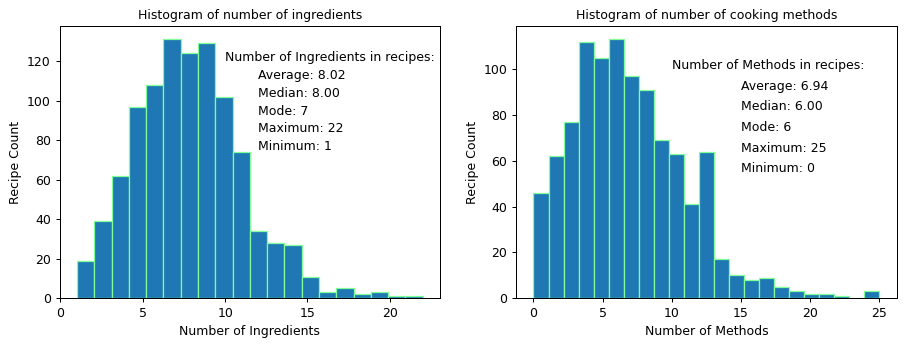

In [43]:
data0=data.copy()
data0['Ingredient Count']=data.drop(columns='Label').iloc[:, :data.columns.get_loc('handle')].sum(axis=1)
data0['Method Count']=data.drop(columns=['Label']).iloc[:, data.columns.get_loc('handle'):].sum(axis=1)
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(data0['Ingredient Count'], bins=20, edgecolor=(0.5,1,0.6))
ax1.set_xlabel('Number of Ingredients')
ax1.set_ylabel('Recipe Count')
ax1.set_title('Histogram of number of ingredients', fontsize=10)
ax1.text(10, 120, 'Number of Ingredients in recipes:')
ax1.text(12, 120-9*1, 'Average: {:.2f}'.format(data0['Ingredient Count'].mean()))
ax1.text(12, 120-9*2, 'Median: {:.2f}'.format(data0['Ingredient Count'].median()))
ax1.text(12, 120-9*3, 'Mode: {}'.format(data0['Ingredient Count'].mode().values[0]))
ax1.text(12, 120-9*4, 'Maximum: {}'.format(data0['Ingredient Count'].max()))
ax1.text(12, 120-9*5, 'Minimum: {}'.format(data0['Ingredient Count'].min()))
###################################################################
ax2.hist(data0['Method Count'], bins=23, edgecolor=(0.5,1,0.6))
ax2.set_xlabel('Number of Methods')
ax2.set_ylabel('Recipe Count')
ax2.set_title('Histogram of number of cooking methods', fontsize=10)
ax2.text(10, 100, 'Number of Methods in recipes:')
ax2.text(15, 100-9*1, 'Average: {:.2f}'.format(data0['Method Count'].mean()))
ax2.text(15, 100-9*2, 'Median: {:.2f}'.format(data0['Method Count'].median()))
ax2.text(15, 100-9*3, 'Mode: {}'.format(data0['Method Count'].mode().values[0]))
ax2.text(15, 100-9*4, 'Maximum: {}'.format(data0['Method Count'].max()))
ax2.text(15, 100-9*5, 'Minimum: {}'.format(data0['Method Count'].min()))
###################################################################
plt.show()

In [44]:
data0.iloc[-5:, -5:]

,dissolved,unbaked,Label,Ingredient Count,Method Count
RecipeID,,,,,
16973,0,0,0,5,4
16947,0,0,1,9,11
23734,1,0,0,6,11
7380,0,0,0,7,6
21838,0,0,0,9,14


In order to get a little more complicated recipes, I am going to use a number (10) for both ingredients and methods which is larger than the median number (8 for ingredients and 6 for methods) to construct new recipes.

### 5.1 Prepare the XGBoost model

In [45]:
############################################
# Train the model with all the recipe data
############################################
X_train_final=data.drop(columns='Label')
y_train_final=data['Label']
############################################
xgboost_param=(0.001, 500, 2, 0.001, 0.8, 0.7)
learning_rate, n_estimators, max_depth, eta, subsample, colsample_bytree=xgboost_param
model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                eta=eta,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                verbosity=0,
                                n_jobs=-1)
model.fit(X_train_final, y_train_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.001, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=0)

### 5.2 Predict Good Recipes

In [49]:
#########################################################################################
# Construct a new recipe data frame which contains all the predicted-to-be-good recipes
#########################################################################################
new_recipes=pd.DataFrame(columns=X_test.columns)
method_begin=new_recipes.columns.get_loc('handle')
new_recipes.columns[method_begin]

'handle'

In [80]:
####################################################################################################
# General new recipes which are different from old recipes regarding both ingredients and methods
####################################################################################################
index=0
for _ in tqdm.tqdm(range(500000)):
    ingredient_value=np.zeros(method_begin, dtype=int)
    method_value=np.zeros(len(X_test.columns)-method_begin, dtype=int)
    ingredient_value[random.sample(list(np.arange(0, method_begin, 1)), 10)]=1
    method_value[random.sample(list(np.arange(0, len(X_test.columns)-method_begin, 1)), 10)]=1
    if list(ingredient_value) not in [list(ele)[:method_begin] for ele in data.drop(columns='Label').values]:
        if list(method_value) not in [list(ele)[method_begin:] for ele in data.drop(columns='Label').values]:
            y_pred=model.predict(pd.DataFrame([np.concatenate([ingredient_value, method_value])], columns=new_recipes.columns))
            if y_pred[0]==1:
                new_recipes=new_recipes.append(pd.DataFrame([np.concatenate([ingredient_value, method_value])], 
                                                            columns=new_recipes.columns, index=[index]))
                index+=1
                print('Find one good recipe')

  0%|          | 1392/500000 [03:58<24:36:00,  5.63it/s]

Find one good recipe


  1%|          | 3378/500000 [09:35<24:44:06,  5.58it/s]

Find one good recipe


  1%|          | 4460/500000 [12:40<24:42:43,  5.57it/s]

Find one good recipe


  2%|▏         | 7826/500000 [22:12<24:24:59,  5.60it/s]

Find one good recipe


  2%|▏         | 8629/500000 [24:29<24:22:52,  5.60it/s]

Find one good recipe


  2%|▏         | 9442/500000 [26:47<24:24:24,  5.58it/s]

Find one good recipe


  2%|▏         | 9960/500000 [28:15<24:20:49,  5.59it/s]

Find one good recipe


  2%|▏         | 10508/500000 [29:48<24:18:54,  5.59it/s]

Find one good recipe


  2%|▏         | 11665/500000 [33:05<24:01:28,  5.65it/s]

Find one good recipe


  3%|▎         | 15024/500000 [42:36<24:29:29,  5.50it/s]

Find one good recipe


  3%|▎         | 16667/500000 [47:14<23:45:12,  5.65it/s]

Find one good recipe


  3%|▎         | 16779/500000 [47:33<23:51:44,  5.63it/s]

Find one good recipe


  4%|▎         | 18230/500000 [51:39<23:42:59,  5.64it/s]

Find one good recipe


  4%|▍         | 19403/500000 [54:58<25:09:22,  5.31it/s]

Find one good recipe


  4%|▍         | 20760/500000 [58:48<23:40:45,  5.62it/s]

Find one good recipe


  4%|▍         | 20816/500000 [58:58<25:15:50,  5.27it/s]

Find one good recipe


  5%|▍         | 23236/500000 [1:05:48<23:43:54,  5.58it/s]

Find one good recipe


  5%|▍         | 23794/500000 [1:07:23<23:33:32,  5.61it/s]

Find one good recipe


  6%|▌         | 27557/500000 [1:18:01<23:28:33,  5.59it/s]

Find one good recipe


  6%|▋         | 32217/500000 [1:31:12<23:41:20,  5.49it/s]

Find one good recipe


  7%|▋         | 33523/500000 [1:34:53<23:11:41,  5.59it/s]

Find one good recipe


  7%|▋         | 33573/500000 [1:35:02<23:13:06,  5.58it/s]

Find one good recipe


  7%|▋         | 33708/500000 [1:35:25<23:11:18,  5.59it/s]

Find one good recipe


  7%|▋         | 35170/500000 [1:39:33<23:08:47,  5.58it/s]

Find one good recipe


  7%|▋         | 36471/500000 [1:43:14<23:00:42,  5.60it/s]

Find one good recipe


  8%|▊         | 38565/500000 [1:49:09<22:44:51,  5.63it/s]

Find one good recipe


  8%|▊         | 38628/500000 [1:49:20<22:36:45,  5.67it/s]

Find one good recipe


  8%|▊         | 38973/500000 [1:50:18<22:49:06,  5.61it/s]

Find one good recipe


  8%|▊         | 39936/500000 [1:53:01<22:43:06,  5.63it/s]

Find one good recipe


  8%|▊         | 41580/500000 [1:57:41<22:44:12,  5.60it/s]

Find one good recipe


  8%|▊         | 41605/500000 [1:57:45<23:15:09,  5.48it/s]

Find one good recipe


  9%|▉         | 43815/500000 [2:04:00<22:33:18,  5.62it/s]

Find one good recipe


  9%|▉         | 44995/500000 [2:07:20<22:52:41,  5.52it/s]

Find one good recipe


  9%|▉         | 45059/500000 [2:07:31<22:57:32,  5.50it/s]

Find one good recipe


 11%|█         | 55182/500000 [2:36:10<21:55:28,  5.64it/s]

Find one good recipe


 12%|█▏        | 59092/500000 [2:47:14<21:56:17,  5.58it/s]

Find one good recipe


 12%|█▏        | 60243/500000 [2:50:30<21:45:25,  5.61it/s]

Find one good recipe


 12%|█▏        | 62325/500000 [2:56:23<21:48:53,  5.57it/s]

Find one good recipe


 13%|█▎        | 64210/500000 [3:01:44<21:36:22,  5.60it/s]

Find one good recipe


 13%|█▎        | 65967/500000 [3:06:42<21:42:13,  5.56it/s]

Find one good recipe


 13%|█▎        | 66390/500000 [3:07:54<21:27:04,  5.61it/s]

Find one good recipe


 14%|█▎        | 67569/500000 [3:11:15<21:23:54,  5.61it/s]

Find one good recipe


 14%|█▎        | 67817/500000 [3:11:57<21:43:10,  5.53it/s]

Find one good recipe


 14%|█▎        | 68148/500000 [3:12:54<21:19:50,  5.62it/s]

Find one good recipe


 15%|█▍        | 74085/500000 [3:29:42<21:13:42,  5.57it/s]

Find one good recipe


 15%|█▍        | 74293/500000 [3:30:17<21:08:25,  5.59it/s]

Find one good recipe


 15%|█▍        | 74633/500000 [3:31:16<21:18:35,  5.54it/s]

Find one good recipe


 15%|█▌        | 76672/500000 [3:37:02<20:58:47,  5.60it/s]

Find one good recipe


 16%|█▌        | 78936/500000 [3:43:27<21:22:46,  5.47it/s]

Find one good recipe


 16%|█▌        | 80056/500000 [3:46:37<21:01:14,  5.55it/s]

Find one good recipe


 16%|█▌        | 80524/500000 [3:47:56<20:56:25,  5.56it/s]

Find one good recipe


 16%|█▌        | 80856/500000 [3:48:53<21:03:06,  5.53it/s]

Find one good recipe


 17%|█▋        | 86542/500000 [4:04:59<21:14:24,  5.41it/s]

Find one good recipe


 18%|█▊        | 87694/500000 [4:08:15<20:26:38,  5.60it/s]

Find one good recipe


 18%|█▊        | 88256/500000 [4:09:51<20:42:50,  5.52it/s]

Find one good recipe


 19%|█▊        | 92758/500000 [4:22:36<20:13:48,  5.59it/s]

Find one good recipe


 19%|█▊        | 93105/500000 [4:23:35<20:13:19,  5.59it/s]

Find one good recipe


 19%|█▉        | 94872/500000 [4:28:35<20:16:00,  5.55it/s]

Find one good recipe


 19%|█▉        | 95295/500000 [4:29:47<19:55:51,  5.64it/s]

Find one good recipe


 19%|█▉        | 95457/500000 [4:30:15<20:02:04,  5.61it/s]

Find one good recipe


 19%|█▉        | 95973/500000 [4:31:43<19:59:56,  5.61it/s]

Find one good recipe


 19%|█▉        | 96154/500000 [4:32:14<20:05:46,  5.58it/s]

Find one good recipe


 19%|█▉        | 96438/500000 [4:33:02<20:08:40,  5.56it/s]

Find one good recipe


 19%|█▉        | 96933/500000 [4:34:26<19:55:44,  5.62it/s]

Find one good recipe


 20%|██        | 100855/500000 [4:45:34<19:50:55,  5.59it/s]

Find one good recipe


 20%|██        | 101479/500000 [4:47:20<19:57:58,  5.54it/s]

Find one good recipe


 21%|██        | 102771/500000 [4:51:00<20:09:49,  5.47it/s]

Find one good recipe


 21%|██        | 105490/500000 [4:58:43<19:23:25,  5.65it/s]

Find one good recipe


 21%|██▏       | 106903/500000 [5:02:43<19:46:41,  5.52it/s]

Find one good recipe


 21%|██▏       | 107095/500000 [5:03:16<19:32:06,  5.59it/s]

Find one good recipe


 22%|██▏       | 108113/500000 [5:06:09<19:31:01,  5.58it/s]

Find one good recipe


 22%|██▏       | 110537/500000 [5:13:02<20:01:07,  5.40it/s]

Find one good recipe


 22%|██▏       | 111636/500000 [5:16:09<19:26:14,  5.55it/s]

Find one good recipe


 22%|██▏       | 112354/500000 [5:18:11<19:15:32,  5.59it/s]

Find one good recipe


 23%|██▎       | 113079/500000 [5:20:14<19:09:59,  5.61it/s]

Find one good recipe


 23%|██▎       | 113973/500000 [5:22:46<19:09:13,  5.60it/s]

Find one good recipe


 23%|██▎       | 113981/500000 [5:22:47<19:16:18,  5.56it/s]

Find one good recipe


 23%|██▎       | 115969/500000 [5:28:26<18:53:55,  5.64it/s]

Find one good recipe


 24%|██▎       | 118299/500000 [5:35:02<18:56:41,  5.60it/s]

Find one good recipe


 24%|██▍       | 120066/500000 [5:40:03<18:49:35,  5.61it/s]

Find one good recipe


 24%|██▍       | 120107/500000 [5:40:10<19:03:36,  5.54it/s]

Find one good recipe


 25%|██▍       | 122706/500000 [5:47:32<18:44:52,  5.59it/s]

Find one good recipe


 25%|██▌       | 126767/500000 [5:59:03<18:28:24,  5.61it/s]

Find one good recipe


 25%|██▌       | 127104/500000 [6:00:01<18:34:34,  5.58it/s]

Find one good recipe


 26%|██▌       | 128312/500000 [6:03:27<18:42:42,  5.52it/s]

Find one good recipe


 26%|██▌       | 129818/500000 [6:07:43<18:25:01,  5.58it/s]

Find one good recipe


 26%|██▌       | 130497/500000 [6:09:39<18:38:36,  5.51it/s]

Find one good recipe


 26%|██▋       | 132392/500000 [6:15:02<18:19:21,  5.57it/s]

Find one good recipe


 27%|██▋       | 132784/500000 [6:16:09<18:37:24,  5.48it/s]

Find one good recipe


 27%|██▋       | 136394/500000 [6:26:23<18:01:16,  5.60it/s]

Find one good recipe


 27%|██▋       | 136629/500000 [6:27:04<18:03:53,  5.59it/s]

Find one good recipe


 27%|██▋       | 137107/500000 [6:28:25<18:07:13,  5.56it/s]

Find one good recipe


 28%|██▊       | 138311/500000 [6:31:50<18:34:10,  5.41it/s]

Find one good recipe


 28%|██▊       | 139500/500000 [6:35:12<18:13:15,  5.50it/s]

Find one good recipe


 28%|██▊       | 139683/500000 [6:35:44<17:49:26,  5.62it/s]

Find one good recipe


 29%|██▊       | 143340/500000 [6:46:06<17:43:07,  5.59it/s]

Find one good recipe


 29%|██▊       | 143507/500000 [6:46:34<17:41:34,  5.60it/s]

Find one good recipe


 29%|██▊       | 143550/500000 [6:46:42<17:44:15,  5.58it/s]

Find one good recipe


 29%|██▉       | 143887/500000 [6:47:39<17:45:04,  5.57it/s]

Find one good recipe


 29%|██▉       | 144814/500000 [6:50:17<17:38:45,  5.59it/s]

Find one good recipe


 31%|███       | 152715/500000 [7:12:43<17:11:59,  5.61it/s]

Find one good recipe


 31%|███       | 153003/500000 [7:13:33<17:14:38,  5.59it/s]

Find one good recipe


 31%|███       | 154607/500000 [7:18:06<17:07:20,  5.60it/s]

Find one good recipe


 31%|███       | 155219/500000 [7:19:50<17:08:57,  5.58it/s]

Find one good recipe


 31%|███       | 155623/500000 [7:20:59<17:59:15,  5.32it/s]

Find one good recipe


 31%|███       | 155927/500000 [7:21:51<17:08:30,  5.58it/s]

Find one good recipe


 32%|███▏      | 157939/500000 [7:27:34<16:59:35,  5.59it/s]

Find one good recipe


 32%|███▏      | 158393/500000 [7:28:51<16:58:10,  5.59it/s]

Find one good recipe


 32%|███▏      | 159733/500000 [7:32:40<16:51:02,  5.61it/s]

Find one good recipe


 32%|███▏      | 160964/500000 [7:36:09<16:51:08,  5.59it/s]

Find one good recipe


 32%|███▏      | 162246/500000 [7:39:53<16:47:07,  5.59it/s]

Find one good recipe


 32%|███▏      | 162491/500000 [7:40:35<16:52:03,  5.56it/s]

Find one good recipe


 33%|███▎      | 163759/500000 [7:44:11<16:39:58,  5.60it/s]

Find one good recipe


 33%|███▎      | 165945/500000 [7:50:23<16:29:08,  5.63it/s]

Find one good recipe


 33%|███▎      | 166477/500000 [7:51:54<16:31:19,  5.61it/s]

Find one good recipe


 33%|███▎      | 166521/500000 [7:52:02<16:34:22,  5.59it/s]

Find one good recipe


 34%|███▍      | 168753/500000 [7:58:22<16:30:40,  5.57it/s]

Find one good recipe


 34%|███▍      | 170638/500000 [8:03:44<16:29:36,  5.55it/s]

Find one good recipe


 34%|███▍      | 170914/500000 [8:04:31<16:20:17,  5.60it/s]

Find one good recipe


 35%|███▍      | 174323/500000 [8:14:17<16:17:30,  5.55it/s]

Find one good recipe


 36%|███▌      | 177939/500000 [8:24:34<16:05:53,  5.56it/s]

Find one good recipe


 36%|███▌      | 178973/500000 [8:27:31<15:56:39,  5.59it/s]

Find one good recipe


 36%|███▌      | 179182/500000 [8:28:07<16:03:30,  5.55it/s]

Find one good recipe


 36%|███▌      | 179801/500000 [8:29:53<16:12:23,  5.49it/s]

Find one good recipe


 36%|███▋      | 182110/500000 [8:36:30<15:57:01,  5.54it/s]

Find one good recipe


 36%|███▋      | 182216/500000 [8:36:48<15:48:20,  5.58it/s]

Find one good recipe


 37%|███▋      | 183452/500000 [8:40:19<15:50:59,  5.55it/s]

Find one good recipe


 37%|███▋      | 183689/500000 [8:41:00<16:11:19,  5.43it/s]

Find one good recipe


 37%|███▋      | 184199/500000 [8:42:27<15:38:52,  5.61it/s]

Find one good recipe


 37%|███▋      | 184937/500000 [8:44:33<15:41:42,  5.58it/s]

Find one good recipe


 37%|███▋      | 185084/500000 [8:44:58<16:18:22,  5.36it/s]

Find one good recipe


 37%|███▋      | 186214/500000 [8:48:11<15:36:37,  5.58it/s]

Find one good recipe


 37%|███▋      | 186683/500000 [8:49:31<15:39:30,  5.56it/s]

Find one good recipe


 37%|███▋      | 186891/500000 [8:50:07<15:40:23,  5.55it/s]

Find one good recipe


 38%|███▊      | 187658/500000 [8:52:18<15:36:45,  5.56it/s]

Find one good recipe


 38%|███▊      | 188389/500000 [8:54:23<15:33:39,  5.56it/s]

Find one good recipe


 38%|███▊      | 188951/500000 [8:55:59<15:26:24,  5.60it/s]

Find one good recipe


 38%|███▊      | 191384/500000 [9:02:55<15:21:10,  5.58it/s]

Find one good recipe


 39%|███▊      | 192838/500000 [9:07:04<15:11:34,  5.62it/s]

Find one good recipe


 39%|███▉      | 194590/500000 [9:12:03<15:15:17,  5.56it/s]

Find one good recipe


 39%|███▉      | 195311/500000 [9:14:07<16:47:17,  5.04it/s]

Find one good recipe


 39%|███▉      | 195602/500000 [9:14:57<18:01:30,  4.69it/s]

Find one good recipe


 39%|███▉      | 196446/500000 [9:17:21<15:01:54,  5.61it/s]

Find one good recipe


 39%|███▉      | 196552/500000 [9:17:39<15:13:32,  5.54it/s]

Find one good recipe


 40%|███▉      | 198932/500000 [9:24:26<14:54:34,  5.61it/s]

Find one good recipe


 40%|████      | 200196/500000 [9:28:02<15:01:32,  5.54it/s]

Find one good recipe


 40%|████      | 201634/500000 [9:32:09<14:59:54,  5.53it/s]

Find one good recipe


 41%|████      | 203422/500000 [9:37:15<14:48:53,  5.56it/s]

Find one good recipe


 41%|████▏     | 207009/500000 [9:47:28<14:36:35,  5.57it/s]

Find one good recipe


 42%|████▏     | 208632/500000 [9:52:06<14:30:55,  5.58it/s]

Find one good recipe


 42%|████▏     | 209530/500000 [9:54:39<14:26:40,  5.59it/s]

Find one good recipe


 42%|████▏     | 211955/500000 [10:01:34<14:25:20,  5.55it/s]

Find one good recipe


 43%|████▎     | 213988/500000 [10:07:22<14:21:03,  5.54it/s]

Find one good recipe


 43%|████▎     | 215748/500000 [10:12:22<14:07:38,  5.59it/s]

Find one good recipe


 43%|████▎     | 216597/500000 [10:14:47<14:23:25,  5.47it/s]

Find one good recipe


 43%|████▎     | 216723/500000 [10:15:09<14:07:22,  5.57it/s]

Find one good recipe


 44%|████▎     | 217920/500000 [10:18:33<14:19:31,  5.47it/s]

Find one good recipe


 44%|████▎     | 218445/500000 [10:20:03<13:58:32,  5.60it/s]

Find one good recipe


 44%|████▎     | 218663/500000 [10:20:40<14:00:54,  5.58it/s]

Find one good recipe


 44%|████▍     | 219469/500000 [10:22:59<14:46:53,  5.27it/s]

Find one good recipe


 44%|████▍     | 221717/500000 [10:29:23<13:56:48,  5.54it/s]

Find one good recipe


 45%|████▍     | 223847/500000 [10:35:27<13:58:31,  5.49it/s]

Find one good recipe


 45%|████▌     | 225743/500000 [10:40:52<13:40:23,  5.57it/s]

Find one good recipe


 45%|████▌     | 226031/500000 [10:41:41<13:36:13,  5.59it/s]

Find one good recipe


 45%|████▌     | 227427/500000 [10:45:40<13:46:34,  5.50it/s]

Find one good recipe


 46%|████▌     | 227564/500000 [10:46:03<13:48:01,  5.48it/s]

Find one good recipe


 46%|████▌     | 228162/500000 [10:47:46<13:37:47,  5.54it/s]

Find one good recipe


 46%|████▌     | 228172/500000 [10:47:47<13:32:17,  5.58it/s]

Find one good recipe


 46%|████▌     | 228431/500000 [10:48:32<13:32:52,  5.57it/s]

Find one good recipe


 46%|████▌     | 228868/500000 [10:49:47<13:32:25,  5.56it/s]

Find one good recipe


 46%|████▌     | 229993/500000 [10:53:00<14:05:13,  5.32it/s]

Find one good recipe


 47%|████▋     | 234606/500000 [11:06:08<13:16:35,  5.55it/s]

Find one good recipe


 47%|████▋     | 237442/500000 [11:14:13<13:16:56,  5.49it/s]

Find one good recipe


 48%|████▊     | 237537/500000 [11:14:29<13:04:40,  5.57it/s]

Find one good recipe


 48%|████▊     | 237864/500000 [11:15:26<13:11:38,  5.52it/s]

Find one good recipe


 48%|████▊     | 242017/500000 [11:27:16<12:52:56,  5.56it/s]

Find one good recipe


 49%|████▊     | 243138/500000 [11:30:28<12:59:42,  5.49it/s]

Find one good recipe


 49%|████▉     | 244445/500000 [11:34:12<12:49:12,  5.54it/s]

Find one good recipe


 49%|████▉     | 245499/500000 [11:37:12<12:42:23,  5.56it/s]

Find one good recipe


 50%|████▉     | 248896/500000 [11:46:53<12:40:49,  5.50it/s]

Find one good recipe


 50%|████▉     | 248960/500000 [11:47:04<12:30:46,  5.57it/s]

Find one good recipe


 50%|████▉     | 249599/500000 [11:48:53<12:31:23,  5.55it/s]

Find one good recipe


 50%|█████     | 251711/500000 [11:54:54<12:23:30,  5.57it/s]

Find one good recipe


 51%|█████     | 253258/500000 [11:59:19<12:19:35,  5.56it/s]

Find one good recipe


 51%|█████     | 255155/500000 [12:04:43<12:15:33,  5.55it/s]

Find one good recipe


 51%|█████     | 255517/500000 [12:05:45<12:10:22,  5.58it/s]

Find one good recipe


 51%|█████▏    | 256770/500000 [12:09:20<12:07:35,  5.57it/s]

Find one good recipe


 52%|█████▏    | 259446/500000 [12:16:58<12:43:49,  5.25it/s]

Find one good recipe


 52%|█████▏    | 259797/500000 [12:17:58<12:01:42,  5.55it/s]

Find one good recipe


 52%|█████▏    | 261854/500000 [12:23:49<11:55:51,  5.54it/s]

Find one good recipe


 53%|█████▎    | 266743/500000 [12:37:46<11:38:11,  5.57it/s]

Find one good recipe


 53%|█████▎    | 267276/500000 [12:39:18<11:47:18,  5.48it/s]

Find one good recipe


 53%|█████▎    | 267472/500000 [12:39:51<11:48:03,  5.47it/s]

Find one good recipe


 54%|█████▎    | 268591/500000 [12:43:03<11:30:58,  5.58it/s]

Find one good recipe


 54%|█████▎    | 268663/500000 [12:43:15<11:30:02,  5.59it/s]

Find one good recipe


 54%|█████▍    | 269527/500000 [12:45:43<11:34:37,  5.53it/s]

Find one good recipe


 54%|█████▍    | 269529/500000 [12:45:43<11:52:45,  5.39it/s]

Find one good recipe


 54%|█████▍    | 269611/500000 [12:45:57<11:28:35,  5.58it/s]

Find one good recipe


 54%|█████▍    | 270329/500000 [12:48:00<11:21:25,  5.62it/s]

Find one good recipe


 54%|█████▍    | 271819/500000 [12:52:15<11:22:07,  5.58it/s]

Find one good recipe


 55%|█████▍    | 274137/500000 [12:58:51<11:21:40,  5.52it/s]

Find one good recipe


 55%|█████▌    | 275851/500000 [13:03:46<11:11:38,  5.56it/s]

Find one good recipe


 56%|█████▌    | 277629/500000 [13:08:50<11:04:22,  5.58it/s]

Find one good recipe


 56%|█████▌    | 278284/500000 [13:10:42<11:09:09,  5.52it/s]

Find one good recipe


 56%|█████▌    | 278588/500000 [13:11:34<11:03:39,  5.56it/s]

Find one good recipe


 56%|█████▌    | 279354/500000 [13:13:48<11:08:27,  5.50it/s]

Find one good recipe


 56%|█████▋    | 282386/500000 [13:22:28<10:52:35,  5.56it/s]

Find one good recipe


 57%|█████▋    | 283873/500000 [13:26:43<10:56:33,  5.49it/s]

Find one good recipe


 57%|█████▋    | 285086/500000 [13:30:11<10:44:20,  5.56it/s]

Find one good recipe


 57%|█████▋    | 286076/500000 [13:33:01<11:00:48,  5.40it/s]

Find one good recipe


 57%|█████▋    | 286221/500000 [13:33:26<10:41:13,  5.56it/s]

Find one good recipe


 57%|█████▋    | 286478/500000 [13:34:10<10:37:52,  5.58it/s]

Find one good recipe


 57%|█████▋    | 286921/500000 [13:35:26<10:41:46,  5.53it/s]

Find one good recipe


 58%|█████▊    | 288377/500000 [13:39:35<10:50:54,  5.42it/s]

Find one good recipe


 58%|█████▊    | 289022/500000 [13:41:26<10:33:29,  5.55it/s]

Find one good recipe


 58%|█████▊    | 289683/500000 [13:43:19<10:32:35,  5.54it/s]

Find one good recipe


 58%|█████▊    | 290474/500000 [13:45:35<10:30:20,  5.54it/s]

Find one good recipe


 58%|█████▊    | 291422/500000 [13:48:17<10:36:59,  5.46it/s]

Find one good recipe


 58%|█████▊    | 291823/500000 [13:49:26<10:32:14,  5.49it/s]

Find one good recipe


 59%|█████▊    | 293610/500000 [13:54:33<10:23:19,  5.52it/s]

Find one good recipe


 59%|█████▊    | 293699/500000 [13:54:48<10:15:42,  5.58it/s]

Find one good recipe


 59%|█████▉    | 293814/500000 [13:55:08<10:18:23,  5.56it/s]

Find one good recipe


 60%|█████▉    | 299156/500000 [14:10:23<10:04:35,  5.54it/s]

Find one good recipe


 60%|█████▉    | 299247/500000 [14:10:39<10:05:18,  5.53it/s]

Find one good recipe


 60%|██████    | 301326/500000 [14:16:36<9:58:28,  5.53it/s] 

Find one good recipe


 61%|██████    | 304110/500000 [14:24:34<9:51:30,  5.52it/s] 

Find one good recipe


 61%|██████    | 304575/500000 [14:25:54<9:58:52,  5.44it/s] 

Find one good recipe


 61%|██████▏   | 306369/500000 [14:31:02<9:38:11,  5.58it/s] 

Find one good recipe


 61%|██████▏   | 306898/500000 [14:32:33<9:54:00,  5.42it/s] 

Find one good recipe


 62%|██████▏   | 310852/500000 [14:43:50<9:27:43,  5.55it/s] 

Find one good recipe


 62%|██████▏   | 311409/500000 [14:45:26<9:24:55,  5.56it/s] 

Find one good recipe


 62%|██████▏   | 311814/500000 [14:46:36<9:30:41,  5.50it/s] 

Find one good recipe


 62%|██████▏   | 312334/500000 [14:48:05<9:26:46,  5.52it/s] 

Find one good recipe


 63%|██████▎   | 314302/500000 [14:53:43<9:21:30,  5.51it/s] 

Find one good recipe


 63%|██████▎   | 314310/500000 [14:53:44<9:18:08,  5.54it/s]

Find one good recipe


 63%|██████▎   | 314387/500000 [14:53:57<9:26:29,  5.46it/s]

Find one good recipe


 63%|██████▎   | 315024/500000 [14:55:47<9:12:07,  5.58it/s] 

Find one good recipe


 63%|██████▎   | 315621/500000 [14:57:29<9:15:31,  5.53it/s] 

Find one good recipe


 64%|██████▎   | 318176/500000 [15:04:48<9:04:54,  5.56it/s] 

Find one good recipe


 64%|██████▎   | 318713/500000 [15:06:21<9:08:14,  5.51it/s] 

Find one good recipe


 65%|██████▍   | 323617/500000 [15:20:22<8:49:58,  5.55it/s] 

Find one good recipe


 65%|██████▍   | 324000/500000 [15:21:28<8:50:09,  5.53it/s]

Find one good recipe


 65%|██████▍   | 324547/500000 [15:23:02<8:59:27,  5.42it/s] 

Find one good recipe


 65%|██████▌   | 325323/500000 [15:25:15<8:45:06,  5.54it/s] 

Find one good recipe


 65%|██████▌   | 325392/500000 [15:25:27<8:46:44,  5.52it/s]

Find one good recipe


 65%|██████▌   | 326167/500000 [15:27:40<8:43:03,  5.54it/s] 

Find one good recipe


 65%|██████▌   | 327443/500000 [15:31:19<8:40:03,  5.53it/s] 

Find one good recipe


 66%|██████▌   | 328648/500000 [15:34:45<8:35:55,  5.54it/s] 

Find one good recipe


 66%|██████▌   | 330488/500000 [15:40:01<8:28:29,  5.56it/s]

Find one good recipe


 66%|██████▋   | 331359/500000 [15:42:31<8:33:37,  5.47it/s]

Find one good recipe


 67%|██████▋   | 333813/500000 [15:49:32<8:30:16,  5.43it/s] 

Find one good recipe


 67%|██████▋   | 335147/500000 [15:53:21<8:12:40,  5.58it/s]

Find one good recipe


 68%|██████▊   | 340275/500000 [16:08:02<7:58:13,  5.57it/s]

Find one good recipe


 68%|██████▊   | 340392/500000 [16:08:22<8:06:14,  5.47it/s]

Find one good recipe


 68%|██████▊   | 340522/500000 [16:08:45<8:04:42,  5.48it/s]

Find one good recipe


 68%|██████▊   | 342156/500000 [16:13:26<8:03:37,  5.44it/s]

Find one good recipe


 69%|██████▉   | 344609/500000 [16:20:27<7:46:35,  5.55it/s]

Find one good recipe


 69%|██████▉   | 345433/500000 [16:22:49<7:44:39,  5.54it/s]

Find one good recipe


 69%|██████▉   | 346953/500000 [16:27:10<7:37:49,  5.57it/s]

Find one good recipe


 69%|██████▉   | 347153/500000 [16:27:45<7:42:42,  5.51it/s]

Find one good recipe


 69%|██████▉   | 347175/500000 [16:27:48<7:41:22,  5.52it/s]

Find one good recipe


 70%|██████▉   | 347645/500000 [16:29:09<7:39:40,  5.52it/s]

Find one good recipe


 70%|██████▉   | 348579/500000 [16:31:50<7:31:30,  5.59it/s]

Find one good recipe


 70%|██████▉   | 349451/500000 [16:34:20<7:31:56,  5.55it/s]

Find one good recipe


 70%|███████   | 351307/500000 [16:39:38<7:30:23,  5.50it/s]

Find one good recipe


 70%|███████   | 351757/500000 [16:40:55<7:28:19,  5.51it/s]

Find one good recipe


 71%|███████   | 353949/500000 [16:47:13<7:25:19,  5.47it/s]

Find one good recipe


 71%|███████   | 353954/500000 [16:47:14<7:28:46,  5.42it/s]

Find one good recipe


 71%|███████   | 355076/500000 [16:50:27<7:12:00,  5.59it/s]

Find one good recipe


 71%|███████▏  | 356534/500000 [16:54:37<7:11:57,  5.54it/s]

Find one good recipe


 72%|███████▏  | 358663/500000 [17:00:43<7:06:06,  5.53it/s]

Find one good recipe


 72%|███████▏  | 360692/500000 [17:06:32<6:58:59,  5.54it/s]

Find one good recipe


 72%|███████▏  | 360987/500000 [17:07:23<6:59:56,  5.52it/s]

Find one good recipe


 72%|███████▏  | 362107/500000 [17:10:36<6:54:28,  5.54it/s]

Find one good recipe


 73%|███████▎  | 364564/500000 [17:17:38<6:48:47,  5.52it/s]

Find one good recipe


 73%|███████▎  | 365121/500000 [17:19:14<6:50:42,  5.47it/s]

Find one good recipe


 74%|███████▍  | 371156/500000 [17:36:33<6:26:23,  5.56it/s]

Find one good recipe


 74%|███████▍  | 372287/500000 [17:39:48<6:30:21,  5.45it/s]

Find one good recipe


 75%|███████▍  | 374947/500000 [17:47:26<6:11:38,  5.61it/s]

Find one good recipe


 76%|███████▌  | 378745/500000 [17:58:20<6:03:57,  5.55it/s]

Find one good recipe


 76%|███████▌  | 380634/500000 [18:03:46<5:59:53,  5.53it/s]

Find one good recipe


 76%|███████▌  | 381210/500000 [18:05:26<5:55:23,  5.57it/s]

Find one good recipe


 76%|███████▋  | 381841/500000 [18:07:14<5:55:27,  5.54it/s]

Find one good recipe


 76%|███████▋  | 381991/500000 [18:07:40<5:59:33,  5.47it/s]

Find one good recipe


 77%|███████▋  | 385111/500000 [18:16:38<5:53:05,  5.42it/s]

Find one good recipe


 77%|███████▋  | 385640/500000 [18:18:10<5:45:31,  5.52it/s]

Find one good recipe


 77%|███████▋  | 385682/500000 [18:18:17<5:45:57,  5.51it/s]

Find one good recipe


 77%|███████▋  | 386583/500000 [18:20:52<5:38:41,  5.58it/s]

Find one good recipe


 77%|███████▋  | 386705/500000 [18:21:14<5:41:50,  5.52it/s]

Find one good recipe


 78%|███████▊  | 389853/500000 [18:30:17<5:36:28,  5.46it/s]

Find one good recipe


 78%|███████▊  | 390840/500000 [18:33:07<5:26:41,  5.57it/s]

Find one good recipe


 78%|███████▊  | 391642/500000 [18:35:25<5:22:33,  5.60it/s]

Find one good recipe


 78%|███████▊  | 391918/500000 [18:36:13<5:22:54,  5.58it/s]

Find one good recipe


 79%|███████▉  | 394625/500000 [18:44:00<5:17:46,  5.53it/s]

Find one good recipe


 79%|███████▉  | 395492/500000 [18:46:29<5:18:17,  5.47it/s]

Find one good recipe


 80%|███████▉  | 398710/500000 [18:55:44<5:01:14,  5.60it/s]

Find one good recipe


 80%|████████  | 401580/500000 [19:04:00<4:56:02,  5.54it/s]

Find one good recipe


 81%|████████  | 405175/500000 [19:14:21<4:41:20,  5.62it/s]

Find one good recipe


 81%|████████  | 406222/500000 [19:17:23<4:42:13,  5.54it/s]

Find one good recipe


 81%|████████▏ | 406855/500000 [19:19:12<4:39:01,  5.56it/s]

Find one good recipe


 82%|████████▏ | 407823/500000 [19:21:59<4:40:43,  5.47it/s]

Find one good recipe


 82%|████████▏ | 409429/500000 [19:26:37<4:34:48,  5.49it/s]

Find one good recipe


 82%|████████▏ | 410254/500000 [19:29:00<4:44:19,  5.26it/s]

Find one good recipe


 83%|████████▎ | 414718/500000 [19:41:52<4:21:44,  5.43it/s]

Find one good recipe


 83%|████████▎ | 415127/500000 [19:43:04<4:16:04,  5.52it/s]

Find one good recipe


 83%|████████▎ | 415900/500000 [19:45:17<4:12:05,  5.56it/s]

Find one good recipe


 84%|████████▍ | 420994/500000 [19:59:57<3:57:57,  5.53it/s]

Find one good recipe


 84%|████████▍ | 421610/500000 [20:01:43<3:53:22,  5.60it/s]

Find one good recipe


 85%|████████▍ | 422690/500000 [20:04:50<3:58:00,  5.41it/s]

Find one good recipe


 85%|████████▍ | 423029/500000 [20:05:49<3:56:10,  5.43it/s]

Find one good recipe


 85%|████████▍ | 423934/500000 [20:08:25<3:55:59,  5.37it/s]

Find one good recipe


 85%|████████▍ | 424424/500000 [20:09:50<3:45:52,  5.58it/s]

Find one good recipe


 85%|████████▌ | 426059/500000 [20:14:32<3:47:31,  5.42it/s]

Find one good recipe


 85%|████████▌ | 426119/500000 [20:14:42<3:42:56,  5.52it/s]

Find one good recipe


 86%|████████▌ | 430880/500000 [20:28:24<3:27:38,  5.55it/s]

Find one good recipe


 86%|████████▌ | 431118/500000 [20:29:05<3:27:15,  5.54it/s]

Find one good recipe


 86%|████████▋ | 431522/500000 [20:30:14<3:26:49,  5.52it/s]

Find one good recipe


 87%|████████▋ | 432698/500000 [20:33:38<3:24:02,  5.50it/s]

Find one good recipe


 87%|████████▋ | 433363/500000 [20:35:32<3:20:49,  5.53it/s]

Find one good recipe


 87%|████████▋ | 436523/500000 [20:44:37<3:16:01,  5.40it/s]

Find one good recipe


 87%|████████▋ | 436990/500000 [20:45:58<3:09:54,  5.53it/s]

Find one good recipe


 88%|████████▊ | 438068/500000 [20:49:04<3:05:30,  5.56it/s]

Find one good recipe


 88%|████████▊ | 441392/500000 [20:58:37<2:56:25,  5.54it/s]

Find one good recipe


 89%|████████▊ | 442941/500000 [21:03:04<2:51:46,  5.54it/s]

Find one good recipe


 89%|████████▉ | 445035/500000 [21:09:05<2:43:45,  5.59it/s]

Find one good recipe


 89%|████████▉ | 446078/500000 [21:12:04<2:42:31,  5.53it/s]

Find one good recipe


 89%|████████▉ | 446417/500000 [21:13:02<2:43:24,  5.47it/s]

Find one good recipe


 89%|████████▉ | 446571/500000 [21:13:29<2:41:33,  5.51it/s]

Find one good recipe


 90%|████████▉ | 448001/500000 [21:17:37<2:36:51,  5.53it/s]

Find one good recipe


 90%|████████▉ | 448399/500000 [21:18:45<2:37:00,  5.48it/s]

Find one good recipe


 90%|████████▉ | 448469/500000 [21:18:58<2:47:10,  5.14it/s]

Find one good recipe


 91%|█████████ | 453613/500000 [21:33:44<2:21:23,  5.47it/s]

Find one good recipe


 91%|█████████ | 454218/500000 [21:35:28<2:18:39,  5.50it/s]

Find one good recipe


 92%|█████████▏| 458099/500000 [21:46:37<2:06:10,  5.54it/s]

Find one good recipe


 92%|█████████▏| 460706/500000 [21:54:07<1:59:37,  5.47it/s]

Find one good recipe


 92%|█████████▏| 461020/500000 [21:55:01<2:03:20,  5.27it/s]

Find one good recipe


 93%|█████████▎| 462984/500000 [22:00:40<1:52:27,  5.49it/s]

Find one good recipe


 93%|█████████▎| 463994/500000 [22:03:34<1:49:26,  5.48it/s]

Find one good recipe


 93%|█████████▎| 466567/500000 [22:10:58<1:52:45,  4.94it/s]

Find one good recipe


 93%|█████████▎| 466584/500000 [22:11:01<1:44:59,  5.30it/s]

Find one good recipe


 94%|█████████▎| 468723/500000 [22:17:10<1:33:33,  5.57it/s]

Find one good recipe


 94%|█████████▍| 469053/500000 [22:18:06<1:33:37,  5.51it/s]

Find one good recipe


 94%|█████████▍| 469147/500000 [22:18:22<1:34:26,  5.44it/s]

Find one good recipe


 94%|█████████▍| 469342/500000 [22:18:56<1:32:17,  5.54it/s]

Find one good recipe


 94%|█████████▍| 469396/500000 [22:19:06<1:31:46,  5.56it/s]

Find one good recipe


 94%|█████████▍| 469934/500000 [22:20:38<1:34:48,  5.29it/s]

Find one good recipe


 94%|█████████▍| 470250/500000 [22:21:33<1:29:34,  5.54it/s]

Find one good recipe


 94%|█████████▍| 470462/500000 [22:22:10<1:32:08,  5.34it/s]

Find one good recipe


 94%|█████████▍| 470788/500000 [22:23:06<1:29:55,  5.41it/s]

Find one good recipe


 95%|█████████▍| 473434/500000 [22:30:42<1:23:18,  5.31it/s]

Find one good recipe


 95%|█████████▍| 474813/500000 [22:34:40<1:15:58,  5.52it/s]

Find one good recipe


 96%|█████████▌| 478456/500000 [22:45:09<1:04:37,  5.56it/s]

Find one good recipe


 96%|█████████▌| 481143/500000 [22:52:53<59:07,  5.32it/s]  

Find one good recipe


 96%|█████████▋| 482181/500000 [22:55:52<53:24,  5.56it/s]  

Find one good recipe


 97%|█████████▋| 484893/500000 [23:03:40<45:42,  5.51it/s]  

Find one good recipe


 97%|█████████▋| 484987/500000 [23:03:56<45:34,  5.49it/s]

Find one good recipe


 97%|█████████▋| 487399/500000 [23:10:52<39:22,  5.33it/s]

Find one good recipe


 98%|█████████▊| 487710/500000 [23:11:46<38:23,  5.34it/s]

Find one good recipe


 98%|█████████▊| 488001/500000 [23:12:36<36:17,  5.51it/s]

Find one good recipe


 98%|█████████▊| 488069/500000 [23:12:48<35:55,  5.53it/s]

Find one good recipe


 98%|█████████▊| 491206/500000 [23:21:50<26:51,  5.46it/s]

Find one good recipe


 99%|█████████▊| 492779/500000 [23:26:22<21:42,  5.54it/s]

Find one good recipe


 99%|█████████▊| 493154/500000 [23:27:27<21:39,  5.27it/s]

Find one good recipe


 99%|█████████▉| 493930/500000 [23:29:41<18:36,  5.44it/s]

Find one good recipe


 99%|█████████▉| 494611/500000 [23:31:39<16:38,  5.40it/s]

Find one good recipe


 99%|█████████▉| 497383/500000 [23:39:37<08:05,  5.39it/s]

Find one good recipe


100%|█████████▉| 499133/500000 [23:44:39<02:36,  5.55it/s]

Find one good recipe


100%|██████████| 500000/500000 [23:47:09<00:00,  5.84it/s]


In [81]:
###########################
# Save new recipes
###########################
with open('../data/processed/new_recipes.pkl', 'wb') as file:
    pickle.dump(new_recipes, file)

In [2]:
with open('../data/processed/new_recipes.pkl', 'rb') as file:
    newrecipes=pickle.load(file)
len(newrecipes)

367

I found 367 candidates for potentially good recipes. I will try some of them to see if the dishes from some of these recipes can be delicious.

## 6. Conclusion

I will try the 8th recipe, and name this dish as gold wings.

In [23]:
newrecipes.columns[newrecipes.iloc[8].values==1]

Index(['dash soy sauce', 'rhubarb', 'chicken wings', 'dijon mustard',
       'unsalted butter  chilled', 'cannellini beans  rinsed', 'corn kernels',
       'cardamom', 'roasted peanuts', 'cayenne pepper', 'tossing', 'running',
       'heaping', 'preheated', 'dusting', 'burning', 'pink', 'pudding',
       'fitted', 'cutting'],
      dtype='object')

## References
[1] Kiddon, Chloé, Luke Zettlemoyer, and Yejin Choi. "Globally coherent text generation with neural checklist models." In Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing, pp. 329-339. 2016.

[2] Majumder, Bodhisattwa Prasad, Shuyang Li, Jianmo Ni, and Julian McAuley. "Generating personalized recipes from historical user preferences." arXiv preprint arXiv:1909.00105 (2019).

[3] https://www.kaggle.com/kanaryayi/recipe-ingredients-and-reviews. 

[4] https://predictivehacks.com/k-means-elbow-method-code-for-python/

[5] https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns

[6] https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

[7] https://datascience.stackexchange.com/questions/57122/in-elbow-curve-how-to-find-the-point-from-where-the-curve-starts-to-rise

[8] https://stackabuse.com/python-for-nlp-topic-modeling/

[9] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
